<H3>    First Name: Balkattu Shreekantha Uttam
<H3>    Last Name: Kannantha
<H3>    USC ID: 9202391620
<H3>    Github UserName: Uttamkannantha

<h4> Importing all the headers

In [1335]:
import glob
import pandas as pd
from scipy.stats import bootstrap
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import statsmodels.discrete.discrete_model as statsModel
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler, label_binarize

from sklearn.metrics import classification_report, multilabel_confusion_matrix,f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
warnings.filterwarnings("ignore")

<h4>1.(a) Reading all the files

In [1336]:
files_names=glob.glob("../data/AReM/*/*.csv")
print("Number of files",len(files_names))

Number of files 88


<h4>1.(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [1337]:

fileNeeded=['dataset1.csv','dataset2.csv','dataset3.csv']
testData=[]
trainData=[]

#extract dataset 1, 2 ,3 and add it to test_files, remaining in train_files
for file in files_names:
    if file.split('/')[-1] in fileNeeded:
        testData.append(file)
    else:
        trainData.append(file)


# remove dataset 3 from bending1 and bending2 from test_files and add it to train_files
for file in testData:
    if file.split('/')[-2]=='bending1' or file.split('/')[-2]=='bending2':
        if file.split('/')[-1]=='dataset3.csv':
            testData.remove(file)
            trainData.append(file)
        

print("Test",len(testData))     
print("Train",len(trainData))     

dfTest = pd.DataFrame(columns=['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'])

#Creating the test dataframe
for file in testData:
        df=pd.read_csv(file,skiprows=4)
        df.columns =['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']   
#         df['activity'] = file.split('/')[-2];
#         df['dataset'] = file.split('/')[-1].split('.')[-2];
        dfTest=pd.concat([dfTest, df], ignore_index=True)
       
#Creating the train data frame 

dfTrain = pd.DataFrame(columns=['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'])              
for file in trainData:
        df = pd.DataFrame()
        if(file == '../data/AReM/bending2/dataset4.csv'):
            df =pd.read_csv(file,skiprows=5,delimiter=' ')
            df =df.T.reset_index().T.reset_index(drop=True)
            df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
            df.columns =['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
#             df['activity'] = 'bending2';
#             df['dataset'] = 'dataset4';
        else:
            df=pd.read_csv(file,skiprows=4)
            df.columns =['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
#             df['activity'] = file.split('/')[-2];
#             df['dataset'] = file.split('/')[-1].split('.')[-2];
        dfTrain=pd.concat([dfTrain, df], ignore_index=True)




Test 19
Train 69


<h4>(c) Feature Extraction

<h4> i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

<h4>Simple statistical features</h4>
Means in each of the 𝑑 dimensions
<br>Standard deviations of the 𝑑 dimensions
<br>Skewness, Kurtosis and Higher order moments of the 𝑑 dimensions
<br>Maximum and Minimum values

<h4>ii. Extract the time-domain features minimum, maximum, mean, median, stan- dard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [1338]:
features=['min','max','mean','median','standard_devation','first_quartile','third_quartile']
# column_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
column_names=['1','2','3','4','5','6']
column_list=[]

for column in column_names:
    for feature in features:
        
        column_list.append(feature+'_'+column)


In [1339]:
featureDataFrame = pd.DataFrame(columns = column_list)

print(len(featureDataFrame.columns))

columnNamesWithTime = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
i =0
for file in files_names:

    df = pd.DataFrame()
    
    if(file == '../data/AReM/bending2/dataset4.csv'):
        df =pd.read_csv(file,skiprows=5,delimiter=' ',names = columnNamesWithTime,index_col = False)
#         df =df.T.reset_index().T.reset_index(drop=True)
#         df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
#         df.columns =['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
#         print(df)
        
    else:
        df = pd.read_csv(file, skiprows = 5, names = columnNamesWithTime)
        
    df = df.drop(['time'], axis=1)
#     print(df.head)
    colFeature = []
        
    for column in df.columns: 
        colFeature.append(df[column].min())
        colFeature.append(df[column].max())          
        colFeature.append(df[column].mean())
        colFeature.append(df[column].median())
        colFeature.append(df[column].std())
        colFeature.append(df[column].quantile(0.25))
        colFeature.append(df[column].quantile(0.75))       
    featureDataFrame = featureDataFrame.append(pd.Series(colFeature, index = featureDataFrame.columns), ignore_index = True)
featureDataFrame



42


min_1  max_1     mean_1 median_1 standard_devation_1 first_quartile_1  \
0   36.25   48.0  43.969125     44.5            1.618364            43.31   
1    37.0   48.0  43.454958    43.25            1.386098             42.5   
2    33.0  47.75  42.179813     43.5            3.670666            39.15   
3    33.0  45.75  41.678063    41.75             2.24349            41.33   
4   37.25   45.0  40.624792     40.5            1.476967            39.25   
..    ...    ...        ...      ...                 ...              ...   
83   18.5  44.25  35.752354     36.0            4.614802             33.0   
84  24.25   45.0  37.177042    36.25            3.581301             34.5   
85  23.33   43.5  36.244083    36.75            3.822016          33.4575   
86  26.25  44.25  36.957458    36.29            3.434863             34.5   
87  27.75  44.67  37.144833    36.33            3.758904             34.0   

   third_quartile_1 min_2  max_2    mean_2  ... standard_devation_5  \
0             44.67   0.0    1.5  0.413125  ...            3.318301   
1              45.0   0.0   1.58  0.378083  ...            2.488862   
2              45.0   0.0    3.0  0.696042  ...            3.849448   
3             42.75   0.0   2.83  0.535979  ...            2.411026   
4              42.0   0.0    1.3  0.358604  ...            2.188449   
..              ...   ...    ...       ...  ...                 ...   
83            39.33   0.0   12.6  3.328104  ...            3.120057   
84            40.25   0.0   8.58  2.374208  ...            2.890347   
85            39.25   0.0   9.71  2.736021  ...            3.617702   
86            40.25   0.0   8.64  2.420083  ...            2.851673   
87             40.5   0.0  10.76  2.419062  ...            2.689291   

   first_quartile_5 third_quartile_5 min_6  max_6    mean_6 median_6  \
0              20.5            23.75   0.0   2.96  0.555313     0.49   
1             22.25             24.0   0.0   5.26  0.679646      0.5   
2           30.4575            36.33   0.0   2.18  0.613521      0.5   
3           28.4575            31.25   0.0   1.79  0.383292     0.43   
4              33.0             36.0   0.0   1.92  0.570583     0.43   
..              ...              ...   ...    ...       ...      ...   
83             14.0          18.0625   0.0   9.39  3.069667     2.77   
84            17.95            21.75   0.0   9.34  2.921729      2.5   
85            15.75             21.0   0.0  11.15    3.5305     3.11   
86             14.0            18.25   0.0   8.34  2.934625    2.525   
87             15.0            18.75   0.0   8.75  2.822437     2.59   

   standard_devation_6 first_quartile_6 third_quartile_6  
0             0.487826              0.0             0.83  
1             0.622534             0.43             0.87  
2             0.524317              0.0              1.0  
3             0.389164              0.0              0.5  
4             0.582915              0.0              1.3  
..                 ...              ...              ...  
83            1.748326           1.7975             4.06  
84              1.8526              1.5              3.9  
85            1.963685             2.17           4.6175  
86             1.63138             1.66             4.03  
87            1.637183             1.58             3.74  

[88 rows x 42 columns]

<h4>iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [1340]:
#for every column in featureDataFrame, calculate the mean and standard deviation and store it in df with first columns as heading of the column and second column as mean and third column as standard deviation
stdMeanDf = pd.DataFrame(columns = ['feature', 'standard_deviation'])
for column in featureDataFrame.columns:
    stdMeanDf = stdMeanDf.append({'feature': column,  'standard_deviation': featureDataFrame[column].std()}, ignore_index = True)

stdMeanDf    


feature standard_deviation
0                 min_1           9.569975
1                 max_1           4.394362
2                mean_1           5.335718
3              median_1           5.440054
4   standard_devation_1           1.772153
5      first_quartile_1            6.15359
6      third_quartile_1           5.138925
7                 min_2                0.0
8                 max_2           5.062729
9                mean_2           1.574164
10             median_2           1.412244
11  standard_devation_2           0.884105
12     first_quartile_2           0.946386
13     third_quartile_2           2.125266
14                min_3           2.956462
15                max_3           4.875137
16               mean_3            4.00838
17             median_3           4.036396
18  standard_devation_3            0.94671
19     first_quartile_3           4.220658
20     third_quartile_3           4.171628
21                min_4                0.0
22                max_4           2.183625
23               mean_4           1.166114
24             median_4           1.145586
25  standard_devation_4           0.458242
26     first_quartile_4            0.84362
27     third_quartile_4           1.552504
28                min_5           6.124001
29                max_5           5.741238
30               mean_5           5.675593
31             median_5           5.813782
32  standard_devation_5           1.024898
33     first_quartile_5           6.096465
34     third_quartile_5            5.53172
35                min_6           0.045838
36                max_6           2.518921
37               mean_6           1.154812
38             median_6           1.086474
39  standard_devation_6           0.517617
40     first_quartile_6           0.758584
41     third_quartile_6           1.523599

In [1341]:
stdMeanDf = pd.DataFrame(columns = ['feature', 'standard_deviation','90% Interval'])
for col in column_list:
    data=featureDataFrame[col].tolist()

    data = (data,)

    bootstrap_ci = bootstrap(data, np.std, confidence_level=0.90, random_state=1, method='percentile')
    
    #view 90% boostrapped confidence interval
    interval = [bootstrap_ci.confidence_interval[0],bootstrap_ci.confidence_interval[1]]
    
    stdMeanDf = stdMeanDf.append({'feature': col,  'standard_deviation': featureDataFrame[col].std() , '90% Interval':interval}, ignore_index = True)
    
stdMeanDf

feature standard_deviation  \
0                 min_1           9.569975   
1                 max_1           4.394362   
2                mean_1           5.335718   
3              median_1           5.440054   
4   standard_devation_1           1.772153   
5      first_quartile_1            6.15359   
6      third_quartile_1           5.138925   
7                 min_2                0.0   
8                 max_2           5.062729   
9                mean_2           1.574164   
10             median_2           1.412244   
11  standard_devation_2           0.884105   
12     first_quartile_2           0.946386   
13     third_quartile_2           2.125266   
14                min_3           2.956462   
15                max_3           4.875137   
16               mean_3            4.00838   
17             median_3           4.036396   
18  standard_devation_3            0.94671   
19     first_quartile_3           4.220658   
20     third_quartile_3           4.171628   
21                min_4                0.0   
22                max_4           2.183625   
23               mean_4           1.166114   
24             median_4           1.145586   
25  standard_devation_4           0.458242   
26     first_quartile_4            0.84362   
27     third_quartile_4           1.552504   
28                min_5           6.124001   
29                max_5           5.741238   
30               mean_5           5.675593   
31             median_5           5.813782   
32  standard_devation_5           1.024898   
33     first_quartile_5           6.096465   
34     third_quartile_5            5.53172   
35                min_6           0.045838   
36                max_6           2.518921   
37               mean_6           1.154812   
38             median_6           1.086474   
39  standard_devation_6           0.517617   
40     first_quartile_6           0.758584   
41     third_quartile_6           1.523599   

                                90% Interval  
0     [8.21734809687677, 10.704231108027612]  
1     [3.306005074433925, 5.269063422099606]  
2     [4.675214277705429, 5.837115077961118]  
3     [4.760293781687243, 5.964648674780459]  
4    [1.562763357753544, 1.9355695999646685]  
5    [5.5423116547107885, 6.603819063160113]  
6     [4.308947238191441, 5.806971606808484]  
7                                 [0.0, 0.0]  
8     [4.595134343103269, 5.377385271413594]  
9    [1.3930997015043582, 1.698067629533194]  
10  [1.2341084184751003, 1.5362962135132616]  
11   [0.7994419005813747, 0.937724463874803]  
12  [0.8282190189749782, 1.0306189562745525]  
13  [1.8893308125793546, 2.2851605257490157]  
14   [2.7474665067017656, 3.092854975416396]  
15   [4.1567892996257285, 5.432534340005044]  
16    [3.400360178299651, 4.467957317072602]  
17   [3.4093641976425353, 4.507902889596203]  
18  [0.7584308326388342, 1.1126652490772608]  
19    [3.6142824530342703, 4.67585068506677]  
20    [3.520758498076233, 4.665291479251779]  
21                                [0.0, 0.0]  
22  [1.9663998082225398, 2.3486724497580997]  
23  [1.0701420011091416, 1.2149273214457532]  
24   [1.0484627248318088, 1.194232007252751]  
25   [0.4196919299614858, 0.484057375209085]  
26  [0.7714178226666526, 0.8855402503167581]  
27    [1.42505809647795, 1.6173715294330346]  
28    [4.388666907023314, 7.450334057963591]  
29   [4.7083624314202295, 6.535202244665587]  
30    [4.406768641672539, 6.676397993107086]  
31    [4.490700893704671, 6.849664587062554]  
32   [0.8055793873431887, 1.211904275466027]  
33    [4.775856081906594, 7.144835697165403]  
34     [4.34070811345779, 6.477834815351388]  
35                [0.0, 0.07802896990623483]  
36   [2.2366109590011405, 2.747930803032685]  
37   [1.057519753694904, 1.2076918772224563]  
38   [0.9908800876414475, 1.141547783343542]  
39  [0.4768712748960195, 0.5419449661971815]  
40  [0.6869136517206835, 0.8032975909009403]  
41   [1.3958686200857724, 1.591174961570593]

<h4>iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

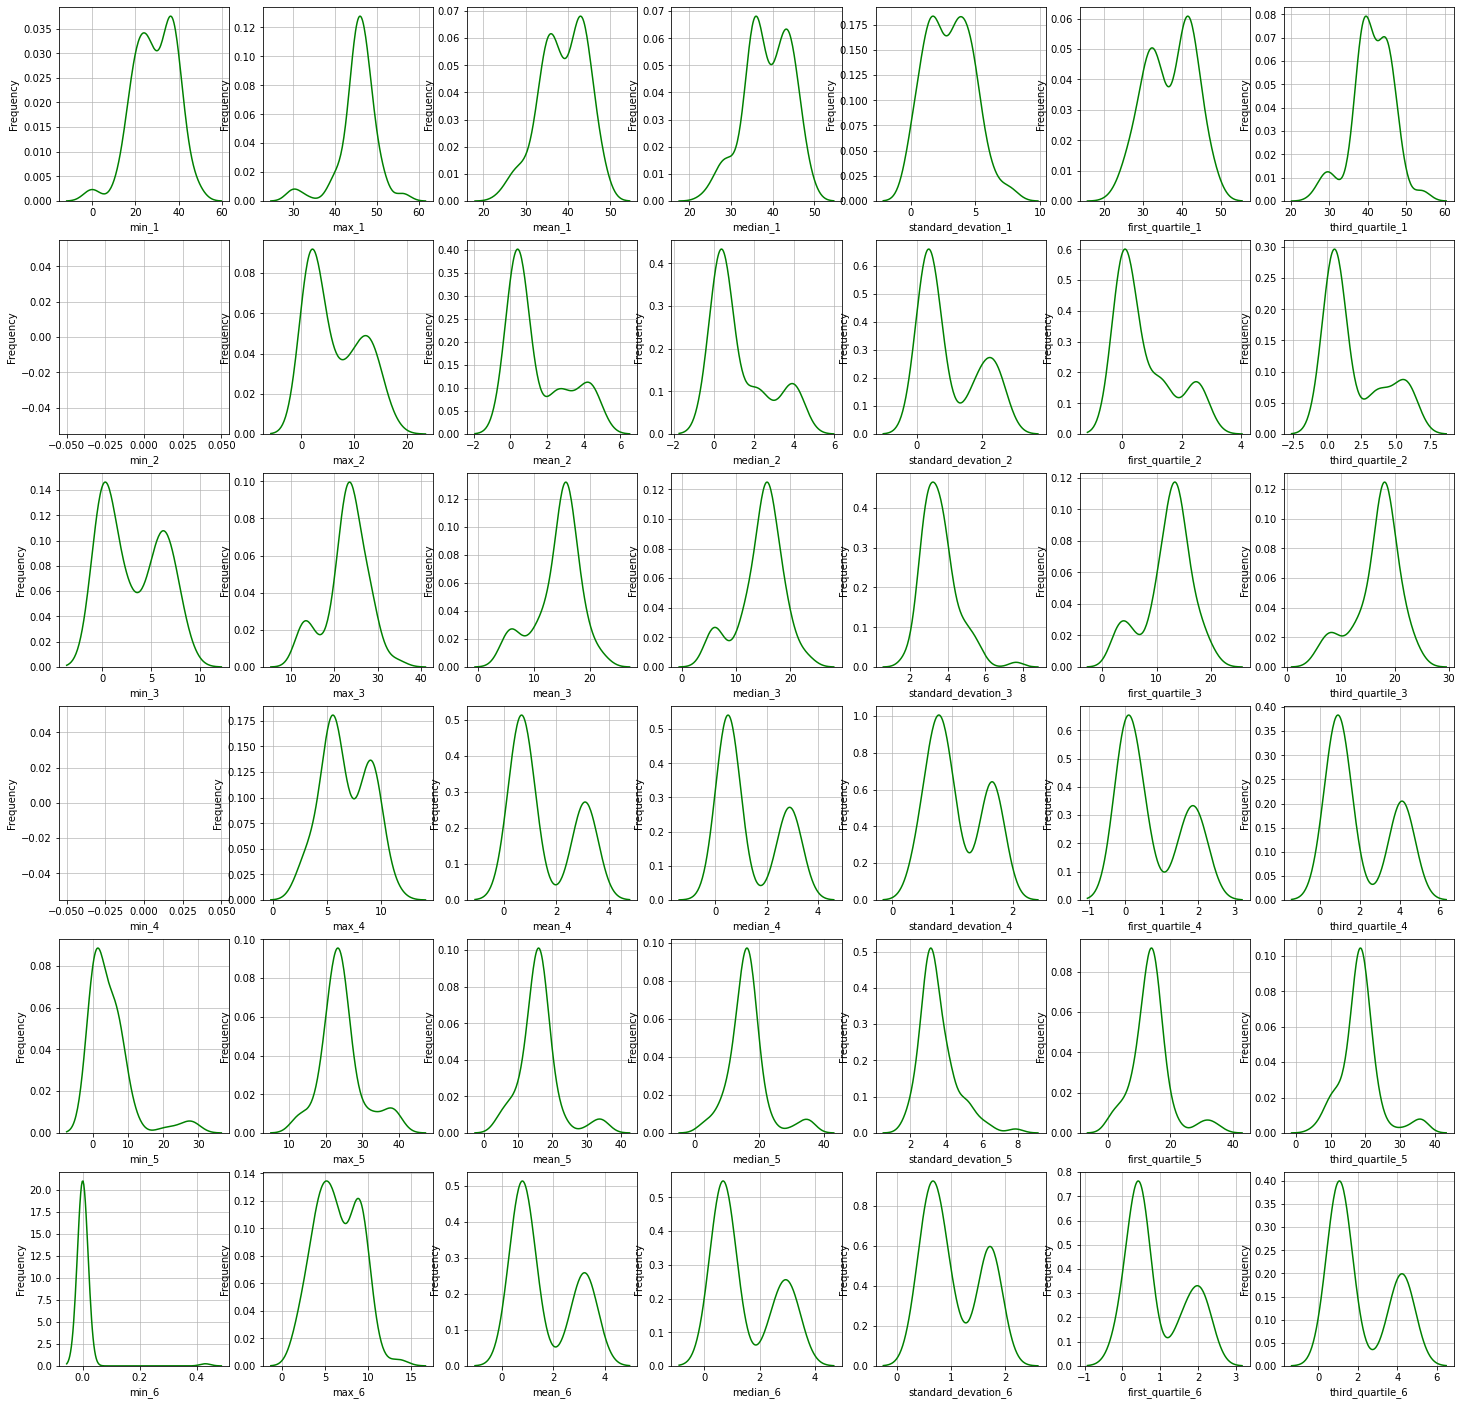

In [1342]:
i=1
plt.figure(figsize=(25,25))

for col in featureDataFrame.columns:
    plt.subplot(6, 7,i)
    sns.kdeplot(featureDataFrame[col], color = 'green')    
    plt.ylabel("Frequency") 
    plt.xlabel(str(col)) 
    plt.grid(True, alpha=.8, linestyle="-") 
    i= i+1
plt.show()

Time series data gives better results when the data spreads over a large range. From the above curve we can say that min, max, and std has better chances to give better results. 

<h4>
2. ISLR 3.7.4

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.

<h4>(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

Ans: Cubic regression will have low RSS as we are increasing the flexibility in cubic regressionn when compared to linerar. Cubic regression might overfit as the data is small and hence in return low RSS

<h4>(b) Answer (a) using test rather than training RSS.

Ans: Here we can expect liner to have low RSS as the model is linear and cubic regression might have overfit the data

<h4>(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

Ans: Cubic model will perform better than linear. If the data is far from liner then the RSS of cubic will be very low when compared to linear but if the data is close to linear then both the model will have very similar or close results. However in general we expect cubic to perform better on training data

<h4>(d) Answer (c) using test rather than training RSS.

Ans: It is difficult to predict the answer as we dont know how far off the data is from being linear. If the data is colse to linear we expect linerar regression to have low RSS on test data but if the data is far off from being linear then we expect cubic to perform better.

<H4>References
    

https://stats.stackexchange.com/questions/50807/features-for-time-series-classification
https://stackoverflow.com/questions/72396854/how-do-i-add-a-header-into-a-dataframe-without-removing-the-first-row
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html
https://www.statology.org/bootstrapping-in-python/#:~:text=The%20basic%20process%20for%20bootstrapping,confidence%20interval%20for%20the%20statistic.
https://www.codespeedy.com/how-to-change-line-color-in-matplotlib/
https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html

<h3>Time Series Classification Part 2: Binary and Multiclass Classification

<h4>(a) Binary Classification Using Logistic Regression3

<h4>i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

In [1343]:
features=['min','max','standard_devation']

column_names=['1','2','6']
column_list=[]

for column in column_names:
    for feature in features:
        
        column_list.append(feature+'_'+column)
column_list

['min_1',
 'max_1',
 'standard_devation_1',
 'min_2',
 'max_2',
 'standard_devation_2',
 'min_6',
 'max_6',
 'standard_devation_6']

In [1344]:
column_list.append('activity')
column_list.append('dataset')
featureDataFrame = pd.DataFrame(columns = column_list)

print(len(featureDataFrame.columns))

print("Test size",len(testData))     
print("Train size",len(trainData)) 

for file in trainData:

    df = pd.DataFrame()
    
    activity =""
    dataset = ""
    if(file == '../data/AReM/bending2/dataset4.csv'):
        df =pd.read_csv(file,skiprows=5,delimiter=' ',names = columnNamesWithTime,index_col = False)
        activity = 'bending2';
        dataset = 'dataset4';
        
        
    else:
        df = pd.read_csv(file, skiprows = 5, names = columnNamesWithTime)
        activity = file.split('/')[-2];
        dataset = file.split('/')[-1].split('.')[-2];
        
    df = df.drop(['time','avg_rss13','var_rss13','avg_rss23'], axis=1)

    colFeature = []
        
    for column in df.columns: 
        colFeature.append(df[column].min())
        colFeature.append(df[column].max())          
        colFeature.append(df[column].std())
    
    colFeature.append(activity)
    colFeature.append(dataset)

    featureDataFrame = featureDataFrame.append(pd.Series(colFeature, index = featureDataFrame.columns), ignore_index = True)
featureDataFrame



11
Test size 19
Train size 69


min_1  max_1 standard_devation_1 min_2  max_2 standard_devation_2 min_6  \
0   36.25   48.0            1.618364   0.0    1.5            0.263111   0.0   
1    37.0   48.0            1.386098   0.0   1.58            0.315566   0.0   
2    33.0  47.75            3.670666   0.0    3.0             0.63086   0.0   
3    33.0  45.75             2.24349   0.0   2.83            0.405469   0.0   
4   18.33  47.67             4.94877   0.0  12.48             2.56868   0.0   
..    ...    ...                 ...   ...    ...                 ...   ...   
64  23.33   43.5            3.822016   0.0   9.71            2.092002   0.0   
65  26.25  44.25            3.434863   0.0   8.64            1.724901   0.0   
66  27.75  44.67            3.758904   0.0  10.76            1.643175   0.0   
67   35.0   47.4            1.558835   0.0    1.7             0.33869   0.0   
68   21.0   50.0            6.238143   0.0    9.9            0.789957   0.0   

    max_6 standard_devation_6  activity    dataset  
0    2.96            0.487826  bending1   dataset7  
1    5.26            0.622534  bending1   dataset6  
2    2.18            0.524317  bending1   dataset4  
3    1.79            0.389164  bending1   dataset5  
4    8.01             1.61729   walking   dataset7  
..    ...                 ...       ...        ...  
64  11.15            1.963685   cycling  dataset14  
65   8.34             1.63138   cycling   dataset8  
66   8.75            1.637183   cycling   dataset9  
67   1.79            0.513506  bending1   dataset3  
68  13.61             1.33298  bending2   dataset3  

[69 rows x 11 columns]

In [1345]:
featureDataFrame['class'] = np.where(featureDataFrame['activity'].isin(['bending1','bending2']), 1, 0)

In [1346]:
featureDataFrame

min_1  max_1 standard_devation_1 min_2  max_2 standard_devation_2 min_6  \
0   36.25   48.0            1.618364   0.0    1.5            0.263111   0.0   
1    37.0   48.0            1.386098   0.0   1.58            0.315566   0.0   
2    33.0  47.75            3.670666   0.0    3.0             0.63086   0.0   
3    33.0  45.75             2.24349   0.0   2.83            0.405469   0.0   
4   18.33  47.67             4.94877   0.0  12.48             2.56868   0.0   
..    ...    ...                 ...   ...    ...                 ...   ...   
64  23.33   43.5            3.822016   0.0   9.71            2.092002   0.0   
65  26.25  44.25            3.434863   0.0   8.64            1.724901   0.0   
66  27.75  44.67            3.758904   0.0  10.76            1.643175   0.0   
67   35.0   47.4            1.558835   0.0    1.7             0.33869   0.0   
68   21.0   50.0            6.238143   0.0    9.9            0.789957   0.0   

    max_6 standard_devation_6  activity    dataset  class  
0    2.96            0.487826  bending1   dataset7      1  
1    5.26            0.622534  bending1   dataset6      1  
2    2.18            0.524317  bending1   dataset4      1  
3    1.79            0.389164  bending1   dataset5      1  
4    8.01             1.61729   walking   dataset7      0  
..    ...                 ...       ...        ...    ...  
64  11.15            1.963685   cycling  dataset14      0  
65   8.34             1.63138   cycling   dataset8      0  
66   8.75            1.637183   cycling   dataset9      0  
67   1.79            0.513506  bending1   dataset3      1  
68  13.61             1.33298  bending2   dataset3      1  

[69 rows x 12 columns]

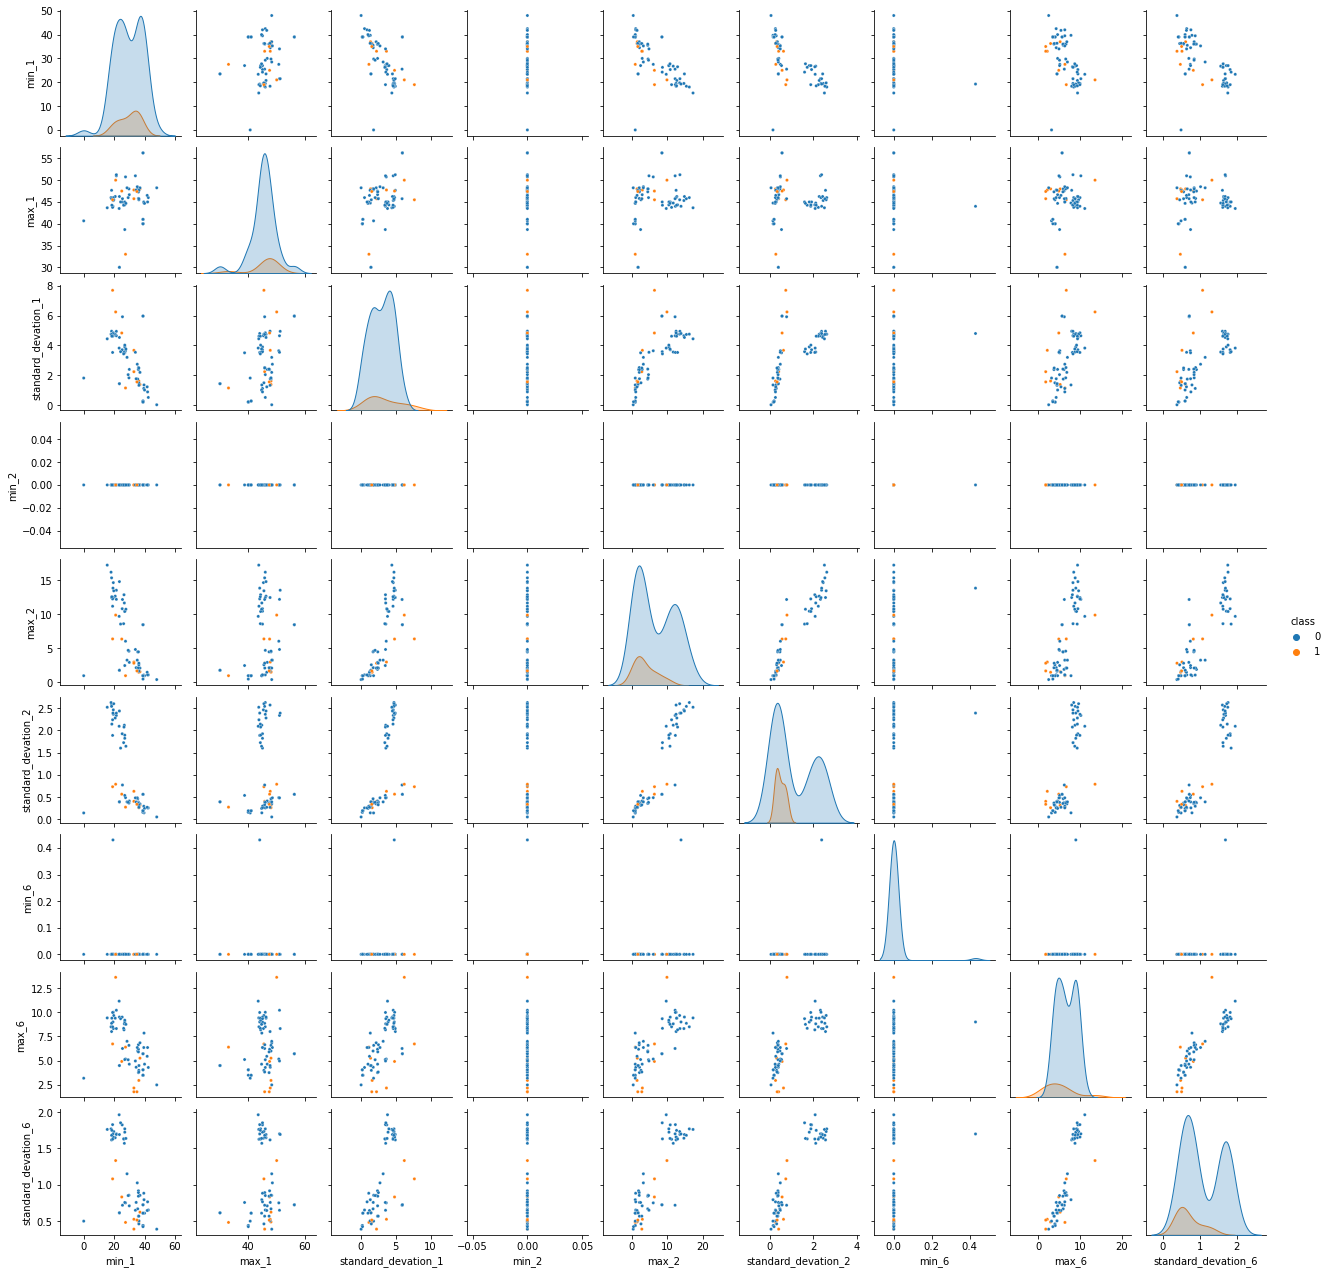

In [1347]:
sns.pairplot(featureDataFrame.drop(['activity','dataset'], axis=1), hue='class', size=2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
plt.show()

<h3>ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [1348]:
half=['upper','lower']

features=['min','max','standard_devation']

column_names=['1','2','6']
column_list=[]


for h in half:
    for column in column_names:
        for feature in features:
            column_list.append(h+'_'+feature+'_'+column)
column_list

column_list.append('activity')
column_list.append('dataset')

In [1349]:
featureDataFrame = pd.DataFrame(columns = column_list)

print(len(featureDataFrame.columns))

print("Test size",len(testData))     
print("Train size",len(trainData)) 

df_1stHalf_col = ['avg_rss12_1stHalf','var_rss12_1stHalf','var_rss23_1stHalf']
df_2ndHalf_col = ['avg_rss12_2ndHalf','var_rss12_2ndHalf','var_rss23_2ndHalf']


for file in trainData:

    df = pd.DataFrame()
    df_1stHalf = pd.DataFrame()
    df_2ndHalf = pd.DataFrame()
    
    activity =""
    dataset = ""
    if(file == '../data/AReM/bending2/dataset4.csv'):
        df =pd.read_csv(file,skiprows=5,delimiter=' ',names = columnNamesWithTime,index_col = False)
        
    else:
        df = pd.read_csv(file, skiprows = 5, names = columnNamesWithTime)

    activity = file.split('/')[-2];
    dataset = file.split('/')[-1].split('.')[-2]; 
    
    df_1stHalf = df[:240]
    df_2ndHalf = df[240:]
    df_1stHalf = df_1stHalf.drop(['time','avg_rss13','var_rss13','avg_rss23'], axis=1)
    df_2ndHalf = df_2ndHalf.drop(['time','avg_rss13','var_rss13','avg_rss23'], axis=1)
    
    df_1stHalf.columns = df_1stHalf_col
    df_2ndHalf.columns = df_2ndHalf_col
#     df_1stHalf.set_axis(['avg_rss12_1stHalf','var_rss12_1stHalf','var_rss23_1stHalf'], axis=1, inplace=True)
#     df_2ndHalf.set_axis(['avg_rss12_2ndHalf','var_rss12_2ndtHalf','var_rss23_2ndHalf'], axis=1, inplace=True)

    df_2ndHalf = df_2ndHalf.reset_index(drop=True)

    
    df = pd.concat([df_1stHalf,df_2ndHalf],axis = 1)
#     print(df)
    colFeature = []
        
    for column in df.columns: 
        colFeature.append(df[column].min())
        colFeature.append(df[column].max())          
        colFeature.append(df[column].std())
    
    colFeature.append(activity)
    colFeature.append(dataset)

    featureDataFrame = featureDataFrame.append(pd.Series(colFeature, index = featureDataFrame.columns), ignore_index = True)
featureDataFrame

20
Test size 19
Train size 69


upper_min_1 upper_max_1 upper_standard_devation_1 upper_min_2 upper_max_2  \
0        36.67        45.0                  1.281976         0.0         1.3   
1         39.0        48.0                  1.359836         0.0         1.3   
2        33.75       47.75                  3.473355         0.0         3.0   
3         33.0       45.75                  3.118644         0.0        2.83   
4        18.33        45.0                  5.143776         0.0       12.44   
..         ...         ...                       ...         ...         ...   
64        27.0       42.67                  3.648495         0.0        9.71   
65       26.25        43.4                  3.462793         0.0        7.46   
66       27.75        44.0                  3.804785         0.0       10.76   
67        36.5        46.5                  1.556971         0.0         1.5   
68        21.0        50.0                  8.743464         0.0         9.9   

   upper_standard_devation_2 upper_min_6 upper_max_6  \
0                   0.284434         0.0        2.28   
1                   0.314099         0.0        5.26   
2                   0.634285         0.0        1.53   
3                   0.489595         0.0        1.79   
4                   2.453111        0.43        7.89   
..                       ...         ...         ...   
64                  2.017423         0.0        9.57   
65                  1.625296         0.0        8.26   
66                  1.668517         0.0        8.75   
67                   0.32954         0.0        1.79   
68                  0.936124         0.0       13.61   

   upper_standard_devation_6 lower_min_1 lower_max_1  \
0                   0.486847       36.25        48.0   
1                   0.718016        37.0        46.5   
2                   0.554542        33.0        46.0   
3                     0.4112       39.25       43.67   
4                   1.565557       20.33       47.67   
..                       ...         ...         ...   
64                  1.952846       23.33        43.5   
65                  1.655499       29.25       44.25   
66                  1.681203        31.0       44.67   
67                  0.526656        35.0        47.4   
68                  1.639122        27.0        36.0   

   lower_standard_devation_1 lower_min_2 lower_max_2  \
0                   1.771251         0.0         1.5   
1                   1.058792         0.0        1.58   
2                   3.537481         0.0        2.86   
3                    0.59592         0.0        1.12   
4                   4.714249         0.0       12.48   
..                       ...         ...         ...   
64                  3.993202         0.0        9.63   
65                  3.411449         0.0        8.64   
66                   3.72041         0.0        7.79   
67                  1.557168         0.0         1.7   
68                  0.941701         0.0        1.87   

   lower_standard_devation_2 lower_min_6 lower_max_6  \
0                   0.235493         0.0        2.96   
1                   0.260761         0.0        4.06   
2                   0.627915         0.0        2.18   
3                    0.27305         0.0         1.5   
4                   2.682846         0.0        8.01   
..                       ...         ...         ...   
64                  2.167337         0.0       11.15   
65                  1.821885         0.0        8.34   
66                  1.620234         0.0        7.93   
67                  0.342346         0.0         1.5   
68                  0.603331         0.0        6.02   

   lower_standard_devation_6  activity    dataset  
0                   0.487918  bending1   dataset7  
1                   0.473445  bending1   dataset6  
2                   0.491873  bending1   dataset4  
3                   0.363144  bending1   dataset5  
4                   1.670593   walking   dataset7  
..                       ...       ...

In [1350]:
featureDataFrame['class'] = np.where(featureDataFrame['activity'].isin(['bending1','bending2']), 1, 0)

In [1351]:
featureDataFrame

upper_min_1 upper_max_1 upper_standard_devation_1 upper_min_2 upper_max_2  \
0        36.67        45.0                  1.281976         0.0         1.3   
1         39.0        48.0                  1.359836         0.0         1.3   
2        33.75       47.75                  3.473355         0.0         3.0   
3         33.0       45.75                  3.118644         0.0        2.83   
4        18.33        45.0                  5.143776         0.0       12.44   
..         ...         ...                       ...         ...         ...   
64        27.0       42.67                  3.648495         0.0        9.71   
65       26.25        43.4                  3.462793         0.0        7.46   
66       27.75        44.0                  3.804785         0.0       10.76   
67        36.5        46.5                  1.556971         0.0         1.5   
68        21.0        50.0                  8.743464         0.0         9.9   

   upper_standard_devation_2 upper_min_6 upper_max_6  \
0                   0.284434         0.0        2.28   
1                   0.314099         0.0        5.26   
2                   0.634285         0.0        1.53   
3                   0.489595         0.0        1.79   
4                   2.453111        0.43        7.89   
..                       ...         ...         ...   
64                  2.017423         0.0        9.57   
65                  1.625296         0.0        8.26   
66                  1.668517         0.0        8.75   
67                   0.32954         0.0        1.79   
68                  0.936124         0.0       13.61   

   upper_standard_devation_6 lower_min_1  ... lower_standard_devation_1  \
0                   0.486847       36.25  ...                  1.771251   
1                   0.718016        37.0  ...                  1.058792   
2                   0.554542        33.0  ...                  3.537481   
3                     0.4112       39.25  ...                   0.59592   
4                   1.565557       20.33  ...                  4.714249   
..                       ...         ...  ...                       ...   
64                  1.952846       23.33  ...                  3.993202   
65                  1.655499       29.25  ...                  3.411449   
66                  1.681203        31.0  ...                   3.72041   
67                  0.526656        35.0  ...                  1.557168   
68                  1.639122        27.0  ...                  0.941701   

   lower_min_2 lower_max_2 lower_standard_devation_2 lower_min_6 lower_max_6  \
0          0.0         1.5                  0.235493         0.0        2.96   
1          0.0        1.58                  0.260761         0.0        4.06   
2          0.0        2.86                  0.627915         0.0        2.18   
3          0.0        1.12                   0.27305         0.0         1.5   
4          0.0       12.48                  2.682846         0.0        8.01   
..         ...         ...                       ...         ...         ...   
64         0.0        9.63                  2.167337         0.0       11.15   
65         0.0        8.64                  1.821885         0.0        8.34   
66         0.0        7.79                  1.620234         0.0        7.93   
67         0.0         1.7                  0.342346         0.0         1.5   
68         0.0        1.87                  0.603331         0.0        6.02   

   lower_standard_devation_6  activity    dataset class  
0                   0.487918  bending1   dataset7     1  
1                   0.473445  bending1   dataset6     1  
2                   0.491873  bending1   dataset4     1  
3                   0.363144  bending1   dataset5     1  
4                   1.670593   walking   dataset7     0  
..                       ...       ...        ...   ...  
64                  1.978396   cycling  dataset14     0  
65                  1.609793   cycling   da

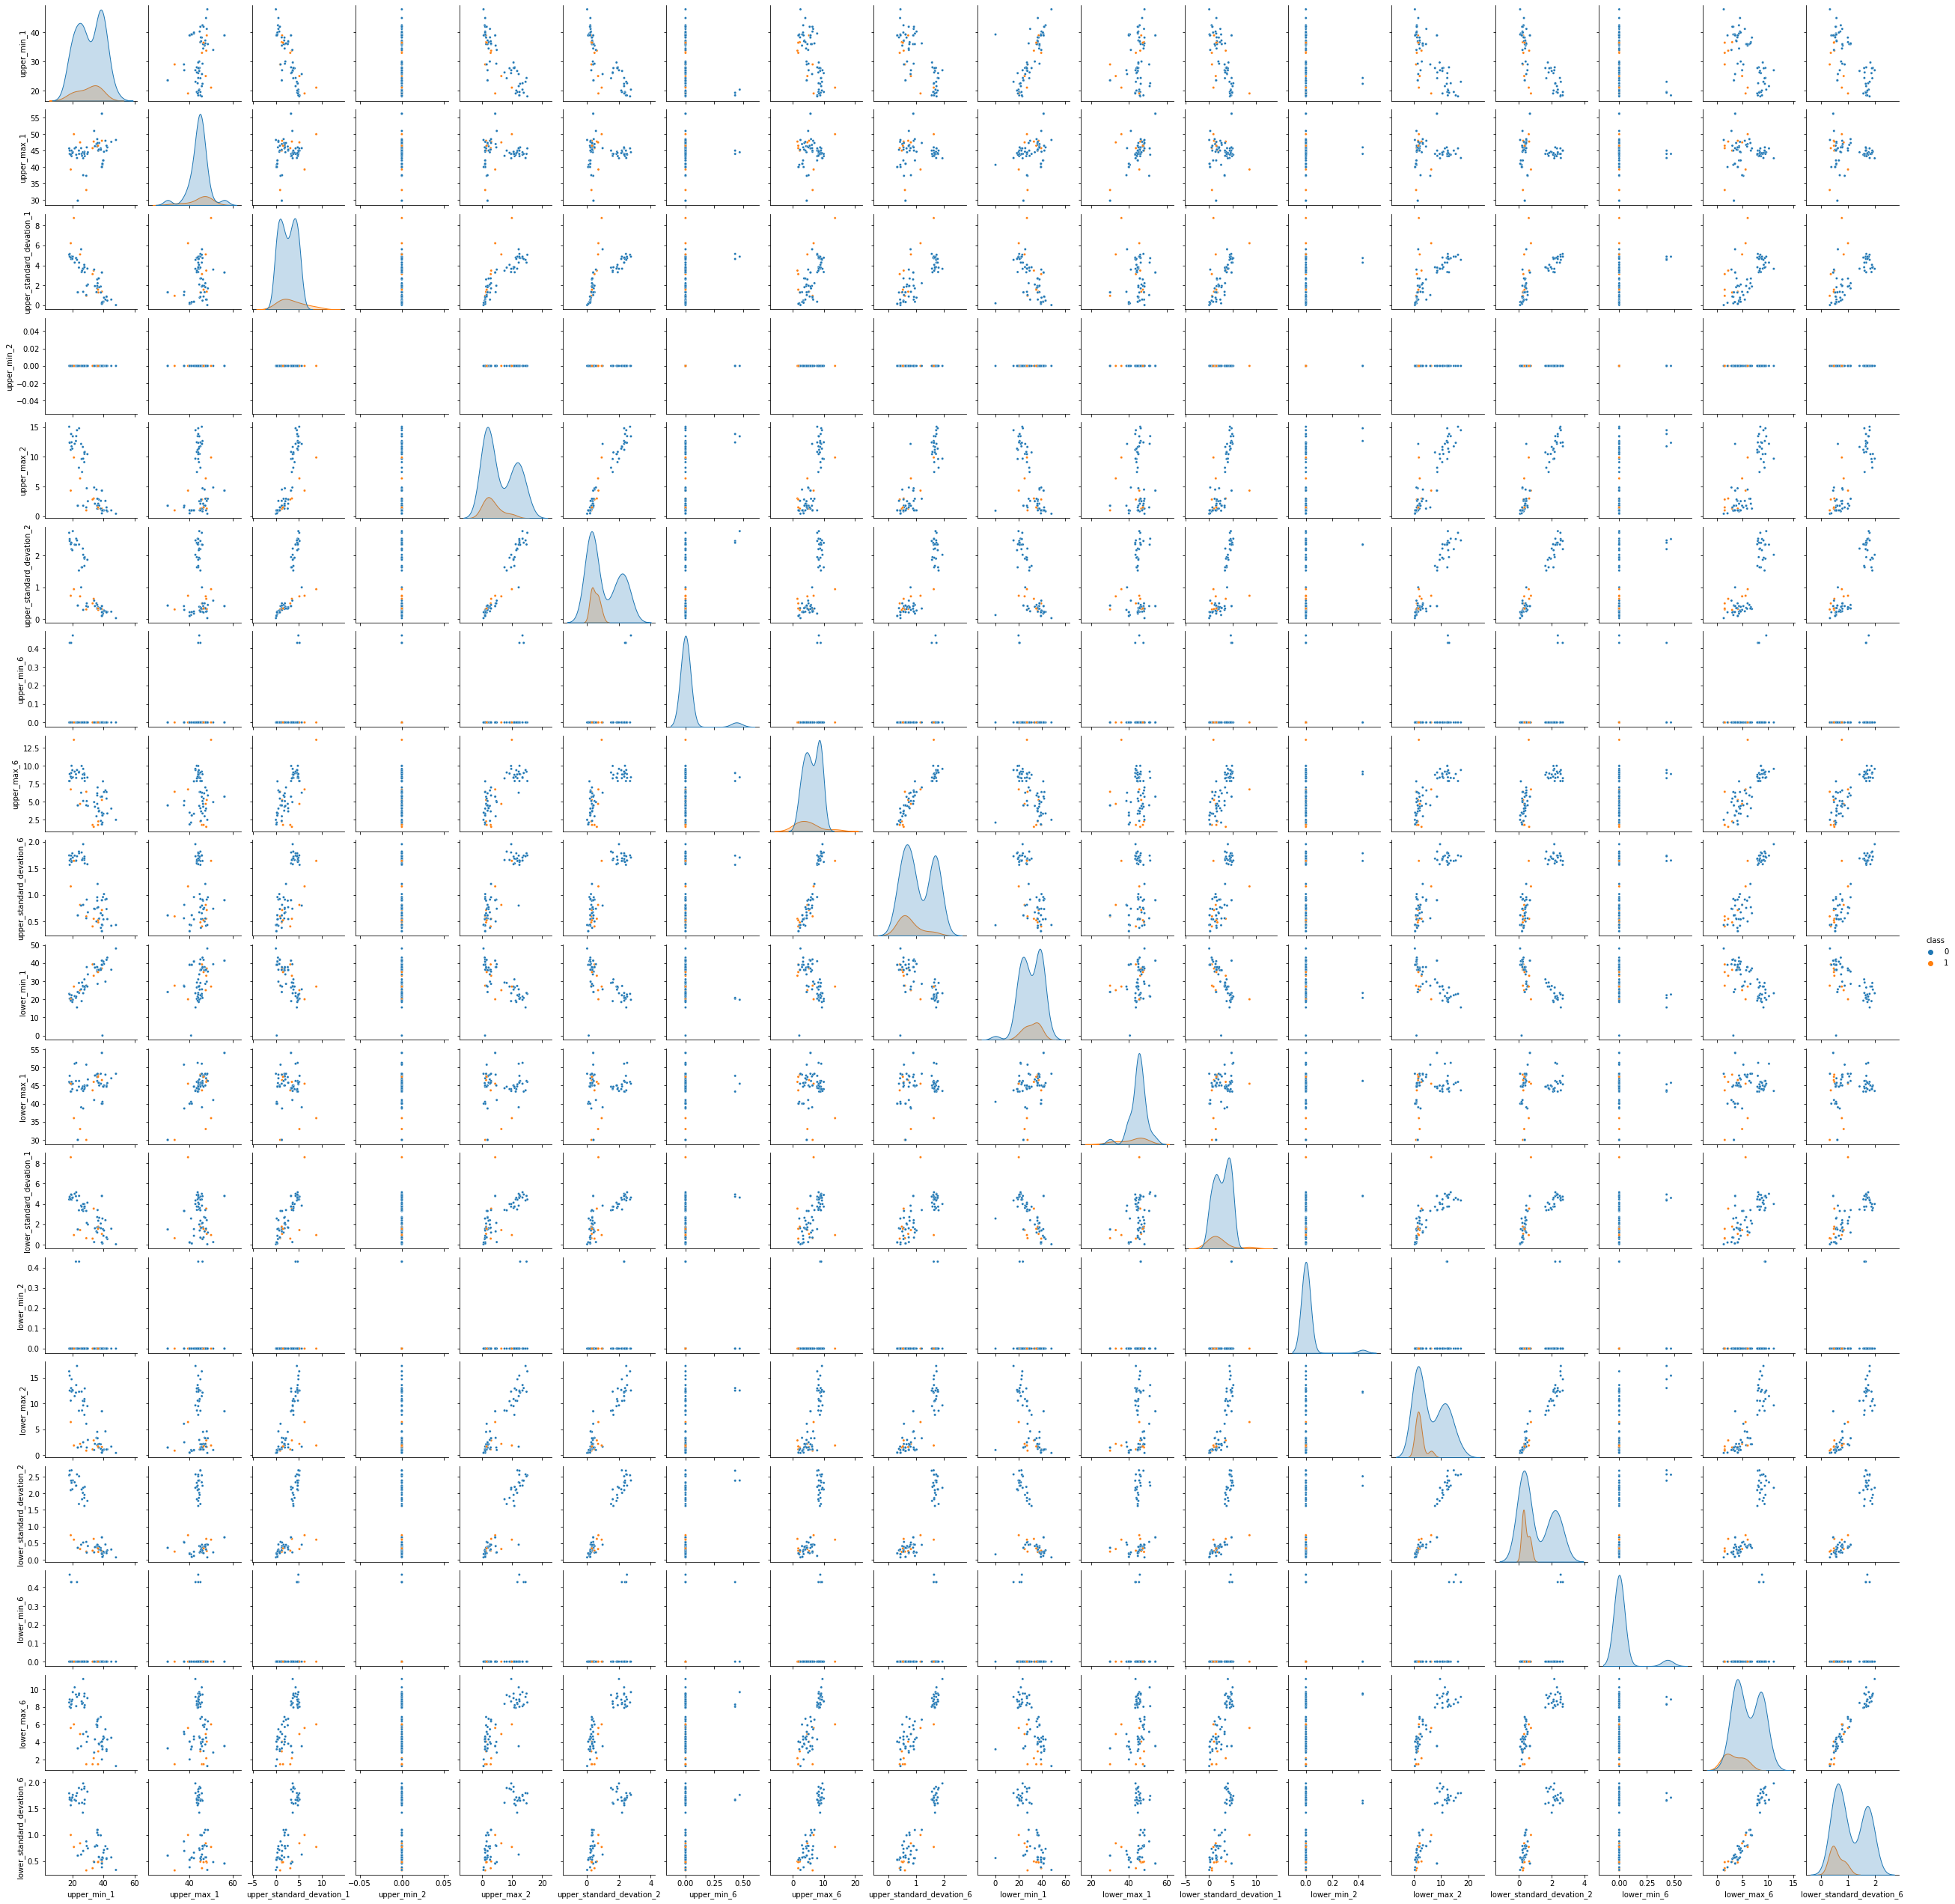

In [1352]:
sns.pairplot(featureDataFrame.drop(['activity','dataset'], axis=1), hue='class', size=2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
plt.show()

<h3>iii) Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features

In [1353]:

def createHeader(splitCount):
    column_list=[]
    features=['min','max','standard_devation']

    column_names=['1','2','3,','4','5','6']

    for i in range(1,splitCount+1):
        for column in column_names:
            for feature in features:
                column_list.append(str(i)+'_'+feature+'_'+column)

    column_list.append('activity')
    column_list.append('dataset')
#     print("colmumn list size: ",len(column_list))
    return column_list

In [1354]:
def readFileAndCalculateFeature(fileNames, splitCount):
    featureDataFrame = pd.DataFrame(columns = createHeader(splitCount))
    for file in fileNames:

        df = pd.DataFrame()

        activity =""
        dataset = ""
        if(file == '../data/AReM/bending2/dataset4.csv'):
            df =pd.read_csv(file,skiprows=5,delimiter=' ',names = columnNamesWithTime,index_col = False)

        else:
            df = pd.read_csv(file, skiprows = 5, names = columnNamesWithTime)
       
        df = df.drop(["time"],axis=1)
#         df = pd.DataFrame(df.to_numpy().reshape(2,-1).T, columns=df.columns.tolist()*2)
        df = np.array_split(df, splitCount)
#         print(df)
        for i in df:
            i = i.reset_index(drop=True)
    
       
        df = pd.concat(df, axis=1,ignore_index = True)
    
#         print(df)
        
        activity = file.split('/')[-2];
        dataset = file.split('/')[-1].split('.')[-2];

        colFeature = []

        for column in df.columns: 
            colFeature.append(df[column].min())
            colFeature.append(df[column].max())          
            colFeature.append(df[column].std())

        colFeature.append(activity)
        colFeature.append(dataset)

        featureDataFrame = featureDataFrame.append(pd.Series(colFeature, index = featureDataFrame.columns), ignore_index = True)
        
    return featureDataFrame
    

In [1355]:

resultMap = {}
for i in range (1,21):
    dataFrame = readFileAndCalculateFeature(trainData,i);
    
    dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']), 1, 0);


    #Select calss as yTrain and rest excluding class and dataset columns as xTrain
    yTrain = dataFrame['class']
    xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)
    
    logReg = LogisticRegression(C=10000, max_iter=10000, random_state=100)
    
    rfecv = RFECV(logReg, step=1, cv=StratifiedKFold(n_splits=5), min_features_to_select= 1)
    
    result = rfecv.fit(xTrain,yTrain)
#     print(result.grid_scores_)
    
    resultMap[i] = [result.n_features_, result.support_, result.ranking_, np.mean(result.grid_scores_)]
    

In [1356]:
optimal_features_number = []
grid_scores_mean = []

print("l          Grid_scores")
print("-----------------------------")

for i in range(1,21):
    optimal_features_number.append(resultMap[i][0])
    grid_scores_mean.append(resultMap[i][3])
    print(i,"     ",resultMap[i][3])
    

print("-----------------------------")

print("Max grid score:",np.max(grid_scores_mean))


l = np.argmax(grid_scores_mean)+1
print("l at maximum grid score: ",l)


pValue = optimal_features_number[(np.argmax(grid_scores_mean))]
print("p value at maximum grid score:",pValue)

print("Best (l,p) pair:",(l,pValue))    
    

l          Grid_scores
-----------------------------
1       0.9025030525030524
2       0.9343406593406594
3       0.9411273911273912
4       0.9298840048840049
5       0.9102686202686204
6       0.9386039886039886
7       0.9512471655328799
8       0.9318986568986569
9       0.9301790801790801
10       0.941959706959707
11       0.9468087468087468
12       0.9519841269841269
13       0.957997557997558
14       0.9566893424036282
15       0.938986568986569
16       0.9450282356532357
17       0.9537240537240538
18       0.9579297245963913
19       0.946696870381081
20       0.9480128205128207
-----------------------------
Max grid score: 0.957997557997558
l at maximum grid score:  13
p value at maximum grid score: 17
Best (l,p) pair: (13, 17)


In [1357]:
consideredFeatures = np.array(resultMap[l][1])
dfConsideredFeatures = pd.DataFrame()
dfConsideredFeatures['FeatureConsideredOrNotConsidered'] = consideredFeatures

print("Number of optimal features selected: ", pValue)
print("Optimal features are obtained at Split count ie. data is split into: ",l)

Number of optimal features selected:  17
Optimal features are obtained at Split count ie. data is split into:  13


In [1358]:
featuresSelected = [] 
for i in range(0,len(consideredFeatures)):
    if(consideredFeatures[i] == True):
        featuresSelected.append(xTrain.columns[i])
        
print(featuresSelected)

['1_max_5', '2_max_1', '2_min_5', '2_max_5', '3_min_5', '3_max_5', '4_max_2', '4_min_5', '7_max_1', '8_min_5', '9_max_1', '10_max_1', '10_min_3,', '11_min_5', '12_min_5', '12_max_6', '13_min_5']


In above list, First Number mean the split part middle part says about the feature and last number points to the column

Right way to cross validation is to utilize the training dataset and do feature selection and cross validation on it and then and fit the model again and do validation. Worng way is to do feature selection before cross validation. Any pre processing done before cross validation will bias the data

In [1359]:
dataFrame = readFileAndCalculateFeature(trainData,l)

dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']), 1, 0);



yTrain = dataFrame['class']

xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)

#remove all the features which are not selected from dataFrame
xTrain = xTrain[featuresSelected]

print(xTrain)
    
logReg = LogisticRegression(C=10000, max_iter=10000, random_state=100)
    
# rfecv = RFECV(logReg, step=1, cv=StratifiedKFold(n_splits=5), min_features_to_select= 1)
    
result = logReg.fit(xTrain,yTrain)

   1_max_5 2_max_1 2_min_5 2_max_5 3_min_5 3_max_5 4_max_2 4_min_5 7_max_1  \
0     28.5    44.5    21.0   30.75    13.0   30.25    0.83    21.0    48.0   
1     33.5   45.25    19.5   28.25    15.0   27.25    1.09    21.0    45.0   
2    37.25    47.5    34.5   38.67    32.0    38.0    1.79    35.0   45.75   
3    35.25    44.6    26.5   30.25    24.0    30.0    1.79   23.67    45.0   
4     20.0    42.5   10.67    20.0     9.5    22.5   11.72    10.0   43.33   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
64    27.0    42.0   12.25    25.5    9.75   26.33    8.86    12.5   42.67   
65    20.0   43.25   10.67   20.75     6.0    21.0    6.47    9.25    43.0   
66    19.5   43.25   12.33    21.0    11.5   20.67     6.8    10.0    43.0   
67    37.5    45.0    34.0   37.33    36.0    37.0     1.5    33.0   46.25   
68    33.5    26.0   17.75    32.5     9.0    32.5     6.5    11.5    36.0   

   8_min_5 9_max_1 10_max_1 10_min_3, 11_min_5 12_min_5 12_max_

<h3> iv) Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [1360]:
yPredictTrain =  result.predict(xTrain)

confusionMatrix = confusion_matrix(yTrain,yPredictTrain)

accuracy = accuracy_score(yTrain, yPredictTrain)

f1Score = f1_score(yTrain, yPredictTrain)

In [1361]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[60  0]
 [ 0  9]]
Accuracy:  1.0
Error 0.0
f1Score:  1.0


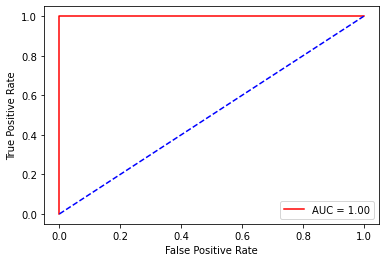

roc Area Under The Curve:  1.0


In [1362]:
falsePosRate, truePosRate, threshold = roc_curve(yTrain, yPredictTrain)

rocAreaUnderTheCurve = auc(falsePosRate, truePosRate)

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.plot(falsePosRate, truePosRate, label = 'AUC = %0.2f' % rocAreaUnderTheCurve, color='red')

plt.legend()

plt.plot([0, 1], [0, 1], color='blue',linestyle='--')

plt.show()

print("roc Area Under The Curve: ",rocAreaUnderTheCurve)

In [1363]:
statsModel

sm = statsModel.Logit(yTrain.astype(float),xTrain.astype(float))
smFit = sm.fit(maxiter=10)
print(smFit.summary())

         Current function value: 0.000035
         Iterations: 10
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                   69
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                           16
Date:                Mon, 17 Oct 2022   Pseudo R-squ.:                  0.9999
Time:                        20:46:06   Log-Likelihood:             -0.0023947
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 6.422e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1_max_5       -0.3342     15.784     -0.021      0.983     -31.270      30.601
2_max_1        0.2852     20.874      0.014      0.989     -40.62

<h4> V). Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [1364]:
testDataFrame = readFileAndCalculateFeature(testData, l)
testDataFrame['class'] = np.where(testDataFrame['activity'].isin(['bending1','bending2']), 1, 0);
testDataFrame

1_min_1 1_max_1 1_standard_devation_1 1_min_2 1_max_2  \
0     39.0    41.5              0.692154     0.0     1.0   
1    41.75   44.25              0.433097    0.43    0.83   
2    23.75   41.33              5.049972     0.5   12.19   
3     24.5    40.5              4.927303    0.43   11.08   
4    24.75   41.33               4.25003    0.94   10.69   
5     14.0   24.75               2.83921     0.0    4.92   
6     26.5    30.0              0.623882     0.0    0.94   
7     46.0    47.0              0.207015     0.0    0.83   
8     38.0    45.0              1.953556     0.0    2.12   
9     37.0    45.0               2.21655     0.0    1.73   
10   41.75   42.25              0.071843     0.0    0.43   
11    37.0   50.75              2.253482     0.0    4.87   
12    45.0   46.67              0.431489     0.0    0.83   
13    28.5    29.0              0.136999     0.0     0.5   
14    29.0    30.0              0.216259     0.0     0.5   
15    48.0    48.0                   0.0     0.0     0.0   
16   30.75   43.25              4.007371     0.0    6.18   
17   33.33   41.75              2.678853     0.0     3.9   
18   31.33    44.0              3.214041     0.0   12.99   

   1_standard_devation_2 1_min_3, 1_max_3, 1_standard_devation_3, 1_min_4  \
0               0.193901     15.0     24.0               3.013535     0.0   
1               0.097311      7.0    25.33               4.869632     0.0   
2               2.367788     11.0    21.33               2.581117    0.83   
3               2.478833     9.75    23.75               3.256028    0.47   
4               2.297201     9.25    20.75               2.967667    0.47   
5               1.163842     18.0    24.75               1.802214     0.0   
6                0.21972      7.5     24.0               4.381079     0.0   
7               0.154443     9.75    18.75               2.287566     0.0   
8                0.34438     7.75    16.75               2.398583     0.0   
9               0.421663      1.5    19.25               4.912701     0.0   
10              0.118992     14.5    19.33               1.362808     0.0   
11              0.961894     16.0     24.0               2.519469     0.0   
12               0.22451     4.33     21.0               3.727822     0.0   
13              0.179221      3.0      9.0               1.507141     0.0   
14              0.212413      1.0      7.5               1.735487     0.0   
15                   0.0      5.0     6.75               0.422461     0.0   
16              1.551903      8.5    23.33                3.66432     0.0   
17              1.008644     8.33     21.0               3.163383     0.0   
18              2.438937      7.0     24.0               4.495571     0.0   

    ... 13_standard_devation_4 13_min_5 13_max_5 13_standard_devation_5  \
0   ...               0.276436    27.25     33.0               1.016372   
1   ...               1.295302     30.0     34.5               1.026549   
2   ...               1.707496     9.33     24.0               3.255492   
3   ...               1.471127     8.75    22.25               3.214852   
4   ...               1.955367     11.0    21.33               2.920005   
5   ...               0.331859     18.0     22.5               1.013997   
6   ...               0.596495     15.0     33.0               4.337307   
7   ...                0.30325    12.25    17.67                1.27943   
8   ...               0.876804     9.75     18.0               1.787828   
9   ...               0.352577     1.33     19.5               3.635907   
10  ...               0.840253      9.5     28.0               4.804757   
11  ...               1.142005      2.0    20.75               4.108176   
12  ...               0.678326    17.67     22.0               1.135665   
13  ...               0.592028     5.25     12.0               1.363085   
14  ...                0.26786      1.0     2.33               0.458544   
15  ...               0.346369      9.0     11.5             

In [1365]:
#Removing the unwanted features and keeping selected features

yTest = testDataFrame['class']

xTest = testDataFrame.drop(['class','activity','dataset'], axis=1)

#remove all the features which are not selected from dataFrame
xTest = xTest[featuresSelected]

# print(yTest)

In [1366]:
yTestPredict = result.predict(xTest)

confusionMatrix = confusion_matrix(yTest,yTestPredict)

accuracy = accuracy_score(yTest, yTestPredict)

f1Score = f1_score(yTest, yTestPredict)

In [1367]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[15  0]
 [ 0  4]]
Accuracy:  1.0
Error 0.0
f1Score:  1.0


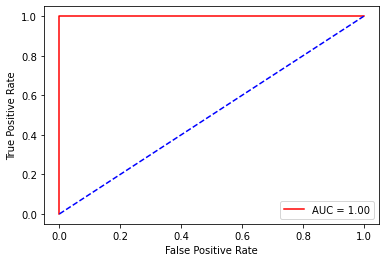

roc Area Under The Curve:  1.0


In [1368]:
falsePosRate, truePosRate, threshold = roc_curve(yTest, yTestPredict)

rocAreaUnderTheCurve = auc(falsePosRate, truePosRate)

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.plot(falsePosRate, truePosRate, label = 'AUC = %0.2f' % rocAreaUnderTheCurve, color='red')

plt.legend()

plt.plot([0, 1], [0, 1], color='blue',linestyle='--')

plt.show()

print("roc Area Under The Curve: ",rocAreaUnderTheCurve)

Previous Cross validation results and current test results both show accuracy of 1 hence both the model is working well. Test has less number of bending data when compared to train data

<h3> vi) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes, the classes are well saperated to cause instability in logisitc regerssion parameters. We can think of using Linear Discriminant Analysis here to see if it gives better results

<h3> vii) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

Confusion matrix clearly shows the imbalence of the data the ratio is 60:9 and 15:4. 

Case control sampling - Upsampling

In [1369]:
resultMap = {}
for i in range (1,21):
    dataFrame = readFileAndCalculateFeature(trainData,i);
    
    dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']), 1, 0);

    df_1 = dataFrame[dataFrame['class']==1] 
    df_0 = dataFrame[dataFrame['class']==0] 
    
    resampled_df = resample(df_1, replace=True, n_samples=60, random_state=100)

    #Select calss as yTrain and rest excluding class and dataset columns as xTrain
    dataFrame = pd.DataFrame()
    dataFrame = pd.concat([df_0, resampled_df])
    
    yTrain = dataFrame['class']
    
    xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)
    
    logReg = LogisticRegression(C=10000, max_iter=10000, random_state=100)
    
    rfecv = RFECV(logReg, step=1, cv=StratifiedKFold(n_splits=5), min_features_to_select= 1)
    
    result = rfecv.fit(xTrain,yTrain)
    
    resultMap[i] = [result.n_features_, result.support_, result.ranking_, np.mean(result.grid_scores_)]

In [1370]:
optimal_features_number = []
grid_scores_mean = []

print("l          Grid_scores")
print("-----------------------------")

for i in range(1,21):
    optimal_features_number.append(resultMap[i][0])
    grid_scores_mean.append(resultMap[i][3])
    print(i,"     ",resultMap[i][3])
    

print("-----------------------------")

print("Max grid score:",np.max(grid_scores_mean))


l = np.argmax(grid_scores_mean)+1
print("l at maximum grid score: ",l)


pValue = optimal_features_number[(np.argmax(grid_scores_mean))]
print("p value at maximum grid score:",pValue)

print("Best (l,p) pair:",(l,pValue))    

l          Grid_scores
-----------------------------
1       0.9425925925925925
2       0.9773148148148147
3       0.9841049382716051
4       0.9810185185185186
5       0.9748148148148147
6       0.9794753086419754
7       0.9832010582010582
8       0.9817129629629628
9       0.9828703703703704
10       0.9795833333333334
11       0.9856481481481482
12       0.9844135802469136
13       0.9913817663817664
14       0.9857473544973544
15       0.980432098765432
16       0.9822337962962964
17       0.9846677559912853
18       0.991358024691358
19       0.9820175438596491
20       0.9847222222222223
-----------------------------
Max grid score: 0.9913817663817664
l at maximum grid score:  13
p value at maximum grid score: 8
Best (l,p) pair: (13, 8)


In [1371]:
consideredFeatures = np.array(resultMap[l][1])
dfConsideredFeatures = pd.DataFrame()
dfConsideredFeatures['FeatureConsideredOrNotConsidered'] = consideredFeatures

print("Number of optimal features selected: ", pValue)
print("Optimal features are obtained at Split count ie. data is split into: ",l)

Number of optimal features selected:  8
Optimal features are obtained at Split count ie. data is split into:  13


In [1372]:
featuresSelected = [] 
for i in range(0,len(consideredFeatures)):
    if(consideredFeatures[i] == True):
        featuresSelected.append(xTrain.columns[i])
        
print(featuresSelected)

['2_min_5', '2_max_5', '4_min_5', '6_min_5', '7_max_1', '9_max_1', '10_max_1', '12_min_5']


In [1373]:
dataFrame = readFileAndCalculateFeature(trainData,l)

dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']), 1, 0);

df_1 = dataFrame[dataFrame['class']==1] 
    
df_0 = dataFrame[dataFrame['class']==0] 
    
    
resampled_df = resample(df_1, replace=True, n_samples=60, random_state=100)

    #Select calss as yTrain and rest excluding class and dataset columns as xTrain
dataFrame = pd.DataFrame()
dataFrame = pd.concat([df_0, resampled_df])
    

yTrain = dataFrame['class']

xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)

#remove all the features which are not selected from dataFrame
xTrain = xTrain[featuresSelected]

# print(xTrain)
    
logReg = LogisticRegression(C=10000, max_iter=10000, random_state=100)
    
# rfecv = RFECV(logReg, step=1, cv=StratifiedKFold(n_splits=5), min_features_to_select= 1)
    
result = logReg.fit(xTrain,yTrain)

In [1374]:
yPredictTrain =  result.predict(xTrain)

confusionMatrix = confusion_matrix(yTrain,yPredictTrain)

accuracy = accuracy_score(yTrain, yPredictTrain)

f1Score = f1_score(yTrain, yPredictTrain)

In [1375]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[60  0]
 [ 0 60]]
Accuracy:  1.0
Error 0.0
f1Score:  1.0


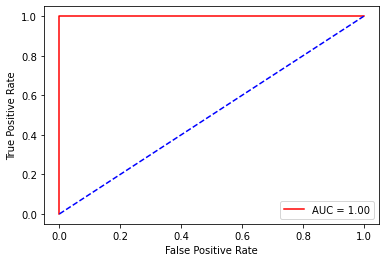

roc Area Under The Curve:  1.0


In [1376]:
falsePosRate, truePosRate, threshold = roc_curve(yTrain, yPredictTrain)

rocAreaUnderTheCurve = auc(falsePosRate, truePosRate)

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.plot(falsePosRate, truePosRate, label = 'AUC = %0.2f' % rocAreaUnderTheCurve, color='red')

plt.legend()

plt.plot([0, 1], [0, 1], color='blue',linestyle='--')

plt.show()

print("roc Area Under The Curve: ",rocAreaUnderTheCurve)

In [1377]:
statsModel

sm = statsModel.Logit(yTrain.astype(float),xTrain.astype(float))
smFit = sm.fit(maxiter=10)
print(smFit.summary())

         Current function value: 0.000059
         Iterations: 10
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  120
Model:                          Logit   Df Residuals:                      112
Method:                           MLE   Df Model:                            7
Date:                Mon, 17 Oct 2022   Pseudo R-squ.:                  0.9999
Time:                        20:48:23   Log-Likelihood:             -0.0070396
converged:                      False   LL-Null:                       -83.178
Covariance Type:            nonrobust   LLR p-value:                 1.482e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
2_min_5        0.6306      6.899      0.091      0.927     -12.891      14.152
2_max_5        0.6947      6.540      0.106      0.915     -12.12

In [1378]:
#Predicting on the test data
testDataFrame = readFileAndCalculateFeature(testData, l)
testDataFrame['class'] = np.where(testDataFrame['activity'].isin(['bending1','bending2']), 1, 0);


In [1379]:
#Removing the unwanted features and keeping selected features

yTest = testDataFrame['class']

xTest = testDataFrame.drop(['class','activity','dataset'], axis=1)

#remove all the features which are not selected from dataFrame
xTest = xTest[featuresSelected]

# print(yTest)

In [1380]:
yTestPredict = result.predict(xTest)

confusionMatrix = confusion_matrix(yTest,yTestPredict)

accuracy = accuracy_score(yTest, yTestPredict)

f1Score = f1_score(yTest, yTestPredict)

In [1381]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[15  0]
 [ 0  4]]
Accuracy:  1.0
Error 0.0
f1Score:  1.0


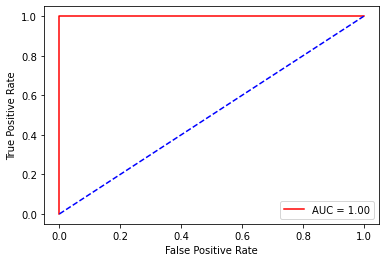

roc Area Under The Curve:  1.0


In [1382]:
falsePosRate, truePosRate, threshold = roc_curve(yTest, yTestPredict)

rocAreaUnderTheCurve = auc(falsePosRate, truePosRate)

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.plot(falsePosRate, truePosRate, label = 'AUC = %0.2f' % rocAreaUnderTheCurve, color='red')

plt.legend()

plt.plot([0, 1], [0, 1], color='blue',linestyle='--')

plt.show()

print("roc Area Under The Curve: ",rocAreaUnderTheCurve)

<h3>e) Binary Classification Using L 1 -penalized logistic regression

<h3> i. Repeat 1(d)iii using L 1 -penalized logistic regression, i.e. instead of using p- values for variable selection, use L 1 regularization. Note that in this problem, you have to cross-validate for both l , the number of time series into which you break each of your instances, and λ , the weight of L 1 penalty in your logistic regression objective function (or C , the budget). Packages usually perform cross-validation for λ automatically. 9

In [1383]:
resultMap = {}
scaler = MinMaxScaler()
for i in range (1,21):
    dataFrame = readFileAndCalculateFeature(trainData,i);
    
    dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']), 1, 0);


    #Select calss as yTrain and rest excluding class and dataset columns as xTrain
    yTrain = dataFrame['class']
    xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)
    
    colsTemp = xTrain.columns
    xTrainNormalized = scaler.fit_transform(xTrain)
    xTrain = pd.DataFrame(xTrainNormalized, columns=colsTemp)
    
    logReg = LogisticRegressionCV(cv=StratifiedKFold(n_splits=5), max_iter=10000, penalty='l1', solver='liblinear', random_state=100 ,class_weight='balanced')
    
    result = logReg.fit(xTrain, yTrain)
    
    cIndex = np.where(result.Cs_ == result.C_)[0][0]  
    best_cv_score = np.mean(list(zip(*result.scores_[1]))[cIndex])

    resultMap[i] = [result.C_[0],best_cv_score]
    

In [1384]:

best_C = []
best_CScores = []

print("l          CV_scores")
print("-----------------------------")

for i in range(1,21):
    best_C.append(resultMap[i][0])
    best_CScores.append(resultMap[i][1])
    print(i,"     ",resultMap[i][0])
    

print("-----------------------------")

print("Max  score:",np.max(best_CScores))


l = np.argmax(best_CScores)+1
print("l at maximum  score: ",l)


C = best_C[(np.argmax(best_CScores))]
print("C value at maximum  score:",C)

print("Best (l,C) pair:",(l,C))   

l          CV_scores
-----------------------------
1       166.81005372000558
2       21.54434690031882
3       21.54434690031882
4       2.782559402207126
5       1291.5496650148827
6       166.81005372000558
7       1291.5496650148827
8       21.54434690031882
9       1291.5496650148827
10       10000.0
11       166.81005372000558
12       2.782559402207126
13       2.782559402207126
14       166.81005372000558
15       166.81005372000558
16       21.54434690031882
17       21.54434690031882
18       2.782559402207126
19       2.782559402207126
20       2.782559402207126
-----------------------------
Max  score: 0.9714285714285715
l at maximum  score:  3
C value at maximum  score: 21.54434690031882
Best (l,C) pair: (3, 21.54434690031882)


In [1385]:
#Fitting the model again for the best l

dataFrame = readFileAndCalculateFeature(trainData,l);
    
dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']), 1, 0);


#Select calss as yTrain and rest excluding class and dataset columns as xTrain
yTrain = dataFrame['class']
xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)
    
colsTemp = xTrain.columns
xTrainNormalized = scaler.fit_transform(xTrain)
xTrain = pd.DataFrame(xTrainNormalized, columns=colsTemp)
    
logReg = LogisticRegressionCV(cv=StratifiedKFold(n_splits=5), max_iter=10000, penalty='l1', solver='liblinear', random_state=100 ,class_weight='balanced')
    
result = logReg.fit(xTrain, yTrain)
    

In [1386]:
yPredictTrain =  result.predict(xTrain)

confusionMatrix = confusion_matrix(yTrain,yPredictTrain)

accuracy = accuracy_score(yTrain, yPredictTrain)

f1Score = f1_score(yTrain, yPredictTrain)

In [1387]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[60  0]
 [ 0  9]]
Accuracy:  1.0
Error 0.0
f1Score:  1.0


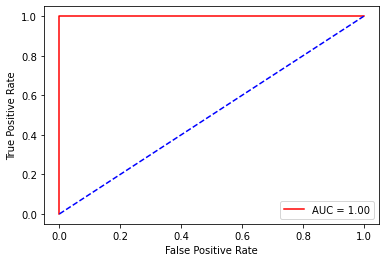

Area Under The Curve:  1.0


In [1388]:
falsePosRate, truePosRate, threshold = roc_curve(yTrain, yPredictTrain)

rocAreaUnderTheCurve = auc(falsePosRate, truePosRate)

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.plot(falsePosRate, truePosRate, label = 'AUC = %0.2f' % rocAreaUnderTheCurve, color='red')

plt.legend()

plt.plot([0, 1], [0, 1], color='blue',linestyle='--')

plt.show()

print("Area Under The Curve: ",rocAreaUnderTheCurve)

In [1389]:
#Predicting on the test data
testDataFrame = readFileAndCalculateFeature(testData, l)
testDataFrame['class'] = np.where(testDataFrame['activity'].isin(['bending1','bending2']), 1, 0);

yTest = testDataFrame['class']

xTest = testDataFrame.drop(['class','activity','dataset'], axis=1)

colsTemp = xTest.columns
xTestNormalized = scaler.fit_transform(xTest)
xTest = pd.DataFrame(xTestNormalized, columns=colsTemp)

In [1390]:
yTestPredict = result.predict(xTest)

confusionMatrix = confusion_matrix(yTest,yTestPredict)

accuracy = accuracy_score(yTest, yTestPredict)

f1Score = f1_score(yTest, yTestPredict)

In [1391]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[14  1]
 [ 1  3]]
Accuracy:  0.8947368421052632
Error 0.10526315789473684
f1Score:  0.75


[0.         0.06666667 1.        ]


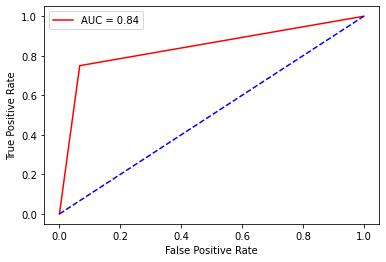

Area Under The Curve:  0.8416666666666667


In [1392]:
falsePosRate, truePosRate, threshold = roc_curve(yTest, yTestPredict)

print(falsePosRate)

rocAreaUnderTheCurve = auc(falsePosRate, truePosRate)

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.plot(falsePosRate, truePosRate, label = 'AUC = %0.2f' % rocAreaUnderTheCurve, color='red')

plt.legend()

plt.plot([0, 1], [0, 1], color='blue',linestyle='--')

plt.show()

print("Area Under The Curve: ",rocAreaUnderTheCurve)

<h3>ii. Compare the L 1 -penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

Both the classifier when ran on test set gave perfect results but the L 1- penalized gave less accuracy on test sample whn comapred to  variable selection method. In terms of implementations L1 is easy to implement and runs faster than variable selection using p-values

<H3> Multi-class Classification (The Realistic Case)

<h3>i. Find the best l in the same way as you found it in 1(e)i to build an L 1 - penalized multinomial regression model to classify all activities in your train- ing set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [1393]:
resultMap = {}
scaler = MinMaxScaler()
for i in range (1,21):
    dataFrame = readFileAndCalculateFeature(trainData,i);
    
    dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']),'bending',dataFrame['activity']);


    #Select calss as yTrain and rest excluding class and dataset columns as xTrain
    yTrain = dataFrame['class']
    xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)
   
    
    colsTemp = xTrain.columns
    xTrainNormalized = scaler.fit_transform(xTrain)
    xTrain = pd.DataFrame(xTrainNormalized, columns=colsTemp)
    
    logReg = LogisticRegressionCV(cv=StratifiedKFold(n_splits=5), multi_class='multinomial', penalty='l1', solver='saga', random_state=100, max_iter=10000)
    
    result = logReg.fit(xTrain, yTrain)
   
    C_index = np.where(result.Cs_ == result.C_[0])[0][0]    
    best_cv_score = np.mean(list(zip(*result.scores_['bending']))[C_index])

    resultMap[i] = [result.C_[0],best_cv_score]

In [1394]:
best_C = []
best_CScores = []

print("l          CV_scores")
print("-----------------------------")

for i in range(1,21):
    best_C.append(resultMap[i][0])
    best_CScores.append(resultMap[i][1])
    print(i,"     ",resultMap[i][0])
    

print("-----------------------------")

print("Max  score:",np.max(best_CScores))


l = np.argmax(best_CScores)+1
print("l at maximum  score: ",l)


C = best_C[(np.argmax(best_CScores))]
print("C value at maximum  score:",C)

print("Best (l,C) pair:",(l,C))   

l          CV_scores
-----------------------------
1       2.782559402207126
2       21.54434690031882
3       21.54434690031882
4       166.81005372000558
5       166.81005372000558
6       166.81005372000558
7       166.81005372000558
8       2.782559402207126
9       1291.5496650148827
10       1291.5496650148827
11       166.81005372000558
12       166.81005372000558
13       166.81005372000558
14       1291.5496650148827
15       1291.5496650148827
16       166.81005372000558
17       166.81005372000558
18       1291.5496650148827
19       166.81005372000558
20       21.54434690031882
-----------------------------
Max  score: 0.8846153846153847
l at maximum  score:  2
C value at maximum  score: 21.54434690031882
Best (l,C) pair: (2, 21.54434690031882)


In [1395]:
#Fitting the model again with choosen l on train data
dataFrame = readFileAndCalculateFeature(trainData,l);
    
dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']),'bending',dataFrame['activity']);


#Select calss as yTrain and rest excluding class and dataset columns as xTrain
yTrain = pd.DataFrame(dataFrame['class'],columns = ['class'])

xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)
   
colsTemp = xTrain.columns
xTrainNormalized = scaler.fit_transform(xTrain)
xTrain = pd.DataFrame(xTrainNormalized, columns=colsTemp)
    
logReg = LogisticRegressionCV(cv=StratifiedKFold(n_splits=5), multi_class='multinomial', penalty='l1', solver='saga', random_state=100, max_iter=10000)
    
result = logReg.fit(xTrain, yTrain)
print(len(xTrain.index))
print(len(yTrain.index))

69
69


In [1396]:
yPredictTrain =  result.predict(xTrain)

confusionMatrix = multilabel_confusion_matrix(yTrain,yPredictTrain)

accuracy = accuracy_score(yTrain, yPredictTrain)

f1Score = f1_score(yTrain, yPredictTrain, average='weighted')

In [1397]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[[60  0]
  [ 0  9]]

 [[57  0]
  [ 0 12]]

 [[57  0]
  [ 0 12]]

 [[57  0]
  [ 0 12]]

 [[57  0]
  [ 0 12]]

 [[57  0]
  [ 0 12]]]
Accuracy:  1.0
Error 0.0
f1Score:  1.0


In [1398]:
#Fitting the model to testing data
dataFrame = readFileAndCalculateFeature(testData,l);
    
dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']),'bending',dataFrame['activity']);


#Select calss as yTrain and rest excluding class and dataset columns as xTrain
yTest = pd.DataFrame(dataFrame['class'],columns = ['class'])
xTest = dataFrame.drop(['class','activity','dataset'], axis=1)
   
colsTemp = xTest.columns
xTestNormalized = scaler.fit_transform(xTest)
xTest = pd.DataFrame(xTestNormalized, columns=colsTemp)

print(len(xTest.index))
print(len(yTest.index))

19
19


In [1399]:
yPredictTest =  result.predict(xTest)

confusionMatrix = multilabel_confusion_matrix(yTest,yPredictTest)

accuracy = accuracy_score(yTest, yPredictTest)

f1Score = f1_score(yTest, yPredictTest, average='weighted')

In [1400]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[[15  0]
  [ 1  3]]

 [[16  0]
  [ 1  2]]

 [[16  0]
  [ 0  3]]

 [[14  2]
  [ 1  2]]

 [[15  1]
  [ 1  2]]

 [[15  1]
  [ 0  3]]]
Accuracy:  0.7894736842105263
Error 0.21052631578947367
f1Score:  0.7954887218045114


In [1401]:
yTrainTemp = yTrain.copy(deep=True)
yTestTemp = yTest.copy(deep=True)


yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'lying',1,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'sitting',2,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'standing',3,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'walking',4,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'cycling',5,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'bending',0,yTrainTemp['class'])


yTrainTemp = yTrainTemp.astype(int)


yTrainTemp = yTrainTemp.to_numpy().flatten()

yTestTemp['class'] = np.where(yTestTemp['class'] == 'lying',1,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'sitting',2,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'standing',3,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'walking',4,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'cycling',5,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'bending',0,yTestTemp['class'])


yTestTemp = yTestTemp.astype(int)


yTestTemp = yTestTemp.to_numpy().flatten()


y_train_bin = label_binarize(yTrainTemp, classes=[0,1,2,3,4,5])
y_test_bin = label_binarize(yTestTemp, classes=[0,1,2,3,4,5])

numClasses = 6

x_train_1 = xTrain.values

x_test_1 = xTest.values


clf = OneVsRestClassifier(LogisticRegression(C=C, multi_class='multinomial', penalty='l1', solver='saga', random_state=100, max_iter=10000)
)

y_train_score = clf.fit(x_train_1, y_train_bin).decision_function(x_train_1)

y_test_score = clf.fit(x_train_1, y_train_bin).decision_function(x_test_1)


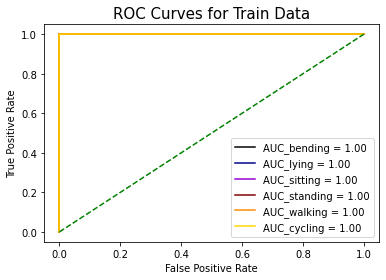

In [1402]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

activities = {0:'bending',1:'lying',2:'sitting',3:'standing',4:'walking',5:'cycling'}
colours = ['black','darkblue','darkviolet','maroon','darkorange','gold']

for i in range(numClasses):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_train_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curves for Train Data', fontsize = 15)
for i in range(numClasses):
    plt.plot(fpr[i], tpr[i], label = 'AUC_{} = %0.2f'.format(activities[i]) % roc_auc[i], color=colours[i])
    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
# plt.xlim([-0.02, 1.02])
# plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [1403]:

auc_scores = []

for i in range(n_classes):
    auc_scores.append(roc_auc[i])

# AUC will be the mean of the AUCs of all classes

auc = np.mean(auc_scores)
auc

1.0

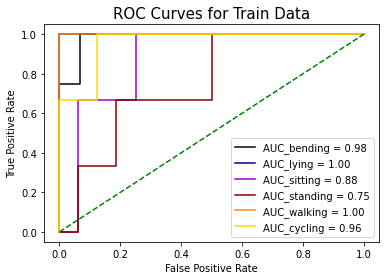

In [1404]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

activities = {0:'bending',1:'lying',2:'sitting',3:'standing',4:'walking',5:'cycling'}
colours = ['black','darkblue','darkviolet','maroon','darkorange','gold']

for i in range(numClasses):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curves for Train Data', fontsize = 15)
for i in range(numClasses):
    plt.plot(fpr[i], tpr[i], label = 'AUC_{} = %0.2f'.format(activities[i]) % roc_auc[i], color=colours[i])
    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
# plt.xlim([-0.02, 1.02])
# plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [1405]:
auc_scores = []

for i in range(n_classes):
    auc_scores.append(roc_auc[i])

# AUC will be the mean of the AUCs of all classes

auc = np.mean(auc_scores)
auc

0.9277777777777777

<h3>ii. Repeat 1(f)i using a Naive Bayes' classifier. Use both Gaussian and Multinomial priors and compare the results.

In [1406]:
resultMap = {}

for i in range (1,21):
    dataFrame = readFileAndCalculateFeature(trainData,i);
    
    dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']),'bending',dataFrame['activity']);


    #Select calss as yTrain and rest excluding class and dataset columns as xTrain
    yTrain = pd.DataFrame(dataFrame['class'],columns = ['class'])
    xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)
   
    
    gnb = GaussianNB() 
    
    params = {}
    gnb_cv = GridSearchCV(estimator=gnb, param_grid=params, cv=StratifiedKFold(n_splits=5))
    
    result = gnb_cv.fit(xTrain,yTrain)
    
    resultMap[i] = [result.best_score_]

In [1407]:

best_scores = []

print("l          scores")
print("-----------------------------")

for i in range(1,21):
    best_scores.append(resultMap[i][0])

    print(i,"     ",resultMap[i][0])
    

print("-----------------------------")

print("Max  score:",np.max(best_scores))


l = np.argmax(best_scores)+1
print("l at maximum  score: ",l)


print("Best (l,C) pair:",(l,C))   

l          scores
-----------------------------
1       0.8846153846153847
2       0.8703296703296705
3       0.7538461538461538
4       0.8263736263736264
5       0.724175824175824
6       0.7538461538461538
7       0.8241758241758241
8       0.7956043956043957
9       0.6934065934065934
10       0.6945054945054945
11       0.7098901098901098
12       0.6230769230769231
13       0.6384615384615385
14       0.6373626373626374
15       0.5945054945054945
16       0.5945054945054945
17       0.5648351648351648
18       0.5076923076923077
19       0.5956043956043956
20       0.5516483516483517
-----------------------------
Max  score: 0.8846153846153847
l at maximum  score:  1
Best (l,C) pair: (1, 21.54434690031882)


In [1408]:
dataFrame = readFileAndCalculateFeature(trainData,l);
    
dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']),'bending',dataFrame['activity']);

#Select calss as yTrain and rest excluding class and dataset columns as xTrain
yTrain = pd.DataFrame(dataFrame['class'],columns = ['class'])
xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)
   
    
gnb = GaussianNB() 

result = gnb.fit(xTrain,yTrain)

In [1409]:
yPredictTrain =  result.predict(xTrain)

confusionMatrix = multilabel_confusion_matrix(yTrain,yPredictTrain)

accuracy = accuracy_score(yTrain, yPredictTrain)

f1Score = f1_score(yTrain, yPredictTrain, average='weighted')

In [1410]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[[60  0]
  [ 1  8]]

 [[57  0]
  [ 0 12]]

 [[53  4]
  [ 0 12]]

 [[57  0]
  [ 1 11]]

 [[57  0]
  [ 2 10]]

 [[57  0]
  [ 0 12]]]
Accuracy:  0.9420289855072463
Error 0.05797101449275366
f1Score:  0.9441109318791959


In [1411]:
dataFrame = readFileAndCalculateFeature(testData,l);
    
dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']),'bending',dataFrame['activity']);


#Select calss as yTrain and rest excluding class and dataset columns as xTrain
yTest = pd.DataFrame(dataFrame['class'],columns = ['class'])
xTest = dataFrame.drop(['class','activity','dataset'], axis=1)

print(len(xTest.index))
print(len(yTest.index))

19
19


In [1412]:
yPredictTest =  result.predict(xTest)

confusionMatrix = multilabel_confusion_matrix(yTest,yPredictTest)

accuracy = accuracy_score(yTest, yPredictTest)

f1Score = f1_score(yTest, yPredictTest, average='weighted')

In [1413]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[[14  1]
  [ 0  4]]

 [[16  0]
  [ 0  3]]

 [[15  1]
  [ 1  2]]

 [[16  0]
  [ 0  3]]

 [[16  0]
  [ 1  2]]

 [[16  0]
  [ 0  3]]]
Accuracy:  0.8947368421052632
Error 0.10526315789473684
f1Score:  0.8923976608187134


In [1414]:

yTrainTemp = yTrain.copy(deep=True)
yTestTemp = yTest.copy(deep=True)

yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'lying',1,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'sitting',2,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'standing',3,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'walking',4,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'cycling',5,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'bending',0,yTrainTemp['class'])


yTrainTemp = yTrainTemp.astype(int)

yTrainTemp = yTrainTemp.to_numpy().flatten()

yTestTemp['class'] = np.where(yTestTemp['class'] == 'lying',1,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'sitting',2,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'standing',3,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'walking',4,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'cycling',5,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'bending',0,yTestTemp['class'])


yTestTemp = yTestTemp.astype(int)

yTestTemp = yTestTemp.to_numpy().flatten()

y_train_bin = label_binarize(yTrainTemp, classes=[0,1,2,3,4,5])
y_test_bin = label_binarize(yTestTemp, classes=[0,1,2,3,4,5])

numClasses = 6

x_train_1 = xTrain.values

x_test_1 = xTest.values

clf = OneVsRestClassifier(gnb)

y_train_score = clf.fit(x_train_1, y_train_bin).predict(x_train_1)
y_test_score = clf.fit(x_train_1, y_train_bin).predict(x_test_1)


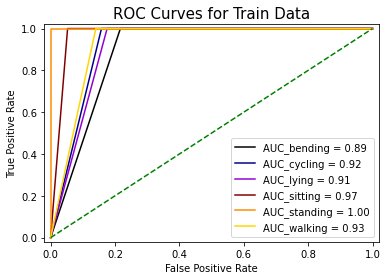

In [1415]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

activities = {0:'bending',1:'cycling',2:'lying',3:'sitting',4:'standing',5:'walking'}
colours = ['black','darkblue','darkviolet','maroon','darkorange','gold']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_train_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curves for Train Data', fontsize = 15)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = 'AUC_{} = %0.2f'.format(activities[i]) % roc_auc[i], color=colours[i])
    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [1416]:
auc_scores = []

for i in range(n_classes):
    auc_scores.append(roc_auc[i])

# AUC will be the mean of the AUCs of all classes

auc = np.mean(auc_scores)
auc

0.9380847953216374

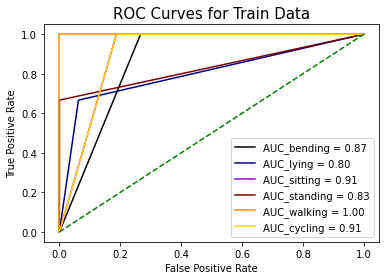

In [1417]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

activities = {0:'bending',1:'lying',2:'sitting',3:'standing',4:'walking',5:'cycling'}
colours = ['black','darkblue','darkviolet','maroon','darkorange','gold']

for i in range(numClasses):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curves for Train Data', fontsize = 15)
for i in range(numClasses):
    plt.plot(fpr[i], tpr[i], label = 'AUC_{} = %0.2f'.format(activities[i]) % roc_auc[i], color=colours[i])
    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
# plt.xlim([-0.02, 1.02])
# plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [1418]:
auc_scores = []

for i in range(n_classes):
    auc_scores.append(roc_auc[i])

# AUC will be the mean of the AUCs of all classes

auc = np.mean(auc_scores)
auc

0.8857638888888889

#Multinominal


In [1419]:
resultMap = {}

for i in range (1,21):
    dataFrame = readFileAndCalculateFeature(trainData,i);
    
    dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']),'bending',dataFrame['activity']);


    #Select calss as yTrain and rest excluding class and dataset columns as xTrain
    yTrain = pd.DataFrame(dataFrame['class'],columns = ['class'])
    xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)
   
    
    mnb = MultinomialNB()
    
    params = {}
    gnb_cv = GridSearchCV(estimator=mnb, param_grid=params, cv=StratifiedKFold(n_splits=5))
    
    result = gnb_cv.fit(xTrain,yTrain)
    
    resultMap[i] = [result.best_score_]

In [1420]:

best_scores = []

print("l          scores")
print("-----------------------------")

for i in range(1,21):
    best_scores.append(resultMap[i][0])

    print(i,"     ",resultMap[i][0])
    

print("-----------------------------")

print("Max  score:",np.max(best_scores))


l = np.argmax(best_scores)+1
print("l at maximum  score: ",l)


print("Best (l,C) pair:",(l,C))   

l          scores
-----------------------------
1       0.6802197802197802
2       0.6802197802197802
3       0.6956043956043956
4       0.7824175824175824
5       0.7835164835164836
6       0.7835164835164835
7       0.7835164835164835
8       0.7967032967032968
9       0.7538461538461538
10       0.8120879120879121
11       0.8263736263736263
12       0.767032967032967
13       0.8120879120879121
14       0.7967032967032966
15       0.7824175824175824
16       0.7978021978021979
17       0.7978021978021979
18       0.7978021978021979
19       0.7824175824175824
20       0.7681318681318682
-----------------------------
Max  score: 0.8263736263736263
l at maximum  score:  11
Best (l,C) pair: (11, 21.54434690031882)


In [1421]:
dataFrame = readFileAndCalculateFeature(trainData,l);
    
dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']),'bending',dataFrame['activity']);

#Select calss as yTrain and rest excluding class and dataset columns as xTrain
yTrain = pd.DataFrame(dataFrame['class'],columns = ['class'])
xTrain = dataFrame.drop(['class','activity','dataset'], axis=1)
   
    
mnb = MultinomialNB() 

result = mnb.fit(xTrain,yTrain)

In [1422]:
yPredictTrain =  result.predict(xTrain)

confusionMatrix = multilabel_confusion_matrix(yTrain,yPredictTrain)

accuracy = accuracy_score(yTrain, yPredictTrain)

f1Score = f1_score(yTrain, yPredictTrain, average='weighted')

In [1423]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[[59  1]
  [ 1  8]]

 [[57  0]
  [ 0 12]]

 [[57  0]
  [ 2 10]]

 [[55  2]
  [ 1 11]]

 [[55  2]
  [ 1 11]]

 [[57  0]
  [ 0 12]]]
Accuracy:  0.927536231884058
Error 0.07246376811594202
f1Score:  0.9279578392621871


In [1424]:
dataFrame = readFileAndCalculateFeature(testData,l);
    
dataFrame['class'] = np.where(dataFrame['activity'].isin(['bending1','bending2']),'bending',dataFrame['activity']);


#Select calss as yTrain and rest excluding class and dataset columns as xTrain
yTest = pd.DataFrame(dataFrame['class'],columns = ['class'])
xTest = dataFrame.drop(['class','activity','dataset'], axis=1)

print(len(xTest.index))
print(len(yTest.index))

19
19


In [1425]:
yPredictTest =  result.predict(xTest)

confusionMatrix = multilabel_confusion_matrix(yTest,yPredictTest)

accuracy = accuracy_score(yTest, yPredictTest)

f1Score = f1_score(yTest, yPredictTest, average='weighted')

In [1426]:
print("Confusion Matrix: ")
print(confusionMatrix)

print("Accuracy: ",accuracy)

print("Error", 1-accuracy)

print("f1Score: ",f1Score)

Confusion Matrix: 
[[[15  0]
  [ 0  4]]

 [[16  0]
  [ 0  3]]

 [[16  0]
  [ 0  3]]

 [[15  1]
  [ 1  2]]

 [[15  1]
  [ 1  2]]

 [[16  0]
  [ 0  3]]]
Accuracy:  0.8947368421052632
Error 0.10526315789473684
f1Score:  0.8947368421052632


In [1427]:

yTrainTemp = yTrain.copy(deep=True)
yTestTemp = yTest.copy(deep=True)

yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'lying',1,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'sitting',2,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'standing',3,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'walking',4,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'cycling',5,yTrainTemp['class'])
yTrainTemp['class'] = np.where(yTrainTemp['class'] == 'bending',0,yTrainTemp['class'])


yTrainTemp = yTrainTemp.astype(int)

yTrainTemp = yTrainTemp.to_numpy().flatten()

yTestTemp['class'] = np.where(yTestTemp['class'] == 'lying',1,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'sitting',2,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'standing',3,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'walking',4,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'cycling',5,yTestTemp['class'])
yTestTemp['class'] = np.where(yTestTemp['class'] == 'bending',0,yTestTemp['class'])


yTestTemp = yTestTemp.astype(int)

yTestTemp = yTestTemp.to_numpy().flatten()

y_train_bin = label_binarize(yTrainTemp, classes=[0,1,2,3,4,5])
y_test_bin = label_binarize(yTestTemp, classes=[0,1,2,3,4,5])

numClasses = 6

x_train_1 = xTrain.values

x_test_1 = xTest.values

clf = OneVsRestClassifier(mnb)

y_train_score = clf.fit(x_train_1, y_train_bin).predict(x_train_1)
y_test_score = clf.fit(x_train_1, y_train_bin).predict(x_test_1)


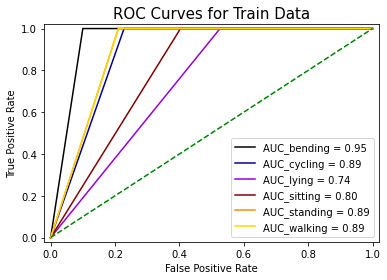

In [1428]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

activities = {0:'bending',1:'cycling',2:'lying',3:'sitting',4:'standing',5:'walking'}
colours = ['black','darkblue','darkviolet','maroon','darkorange','gold']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_train_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curves for Train Data', fontsize = 15)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = 'AUC_{} = %0.2f'.format(activities[i]) % roc_auc[i], color=colours[i])
    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [1429]:
auc_scores = []

for i in range(n_classes):
    auc_scores.append(roc_auc[i])

# AUC will be the mean of the AUCs of all classes

auc = np.mean(auc_scores)
auc

0.8600877192982456

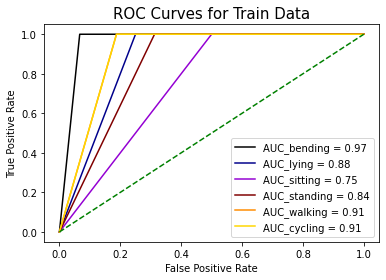

In [1430]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

activities = {0:'bending',1:'lying',2:'sitting',3:'standing',4:'walking',5:'cycling'}
colours = ['black','darkblue','darkviolet','maroon','darkorange','gold']

for i in range(numClasses):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# figure(figsize=(5, 5), dpi=80)
plt.title('ROC Curves for Train Data', fontsize = 15)
for i in range(numClasses):
    plt.plot(fpr[i], tpr[i], label = 'AUC_{} = %0.2f'.format(activities[i]) % roc_auc[i], color=colours[i])
    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color='green')
# plt.xlim([-0.02, 1.02])
# plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate',fontsize = 10)
plt.xlabel('False Positive Rate',fontsize = 10)
plt.show()

In [1431]:
auc_scores = []

for i in range(n_classes):
    auc_scores.append(roc_auc[i])

# AUC will be the mean of the AUCs of all classes

auc = np.mean(auc_scores)
auc

0.8746527777777778

<h3> iii)Which method is better for multi-class classification in this problem?

Accuracy and Error for L1 Penalized, Gaussian Naıve Bayes, Multinomial Naıve Bayes is as below

L 1 - penalized multinomial regression <br>
Accuracy:  0.7894736842105263<br>
Error 0.21052631578947367<br>


Gaussian	<br>
Accuracy:  0.8947368421052632<br>
Error 0.10526315789473684<br>


Multinominal<br>
Accuracy:  0.8947368421052632<br>
Error 0.10526315789473684<br>

From the above number it is clear that Gaussian multi classification is performing better. So for this dataset this algoritm works better



<h4>ISLR 4.8.7

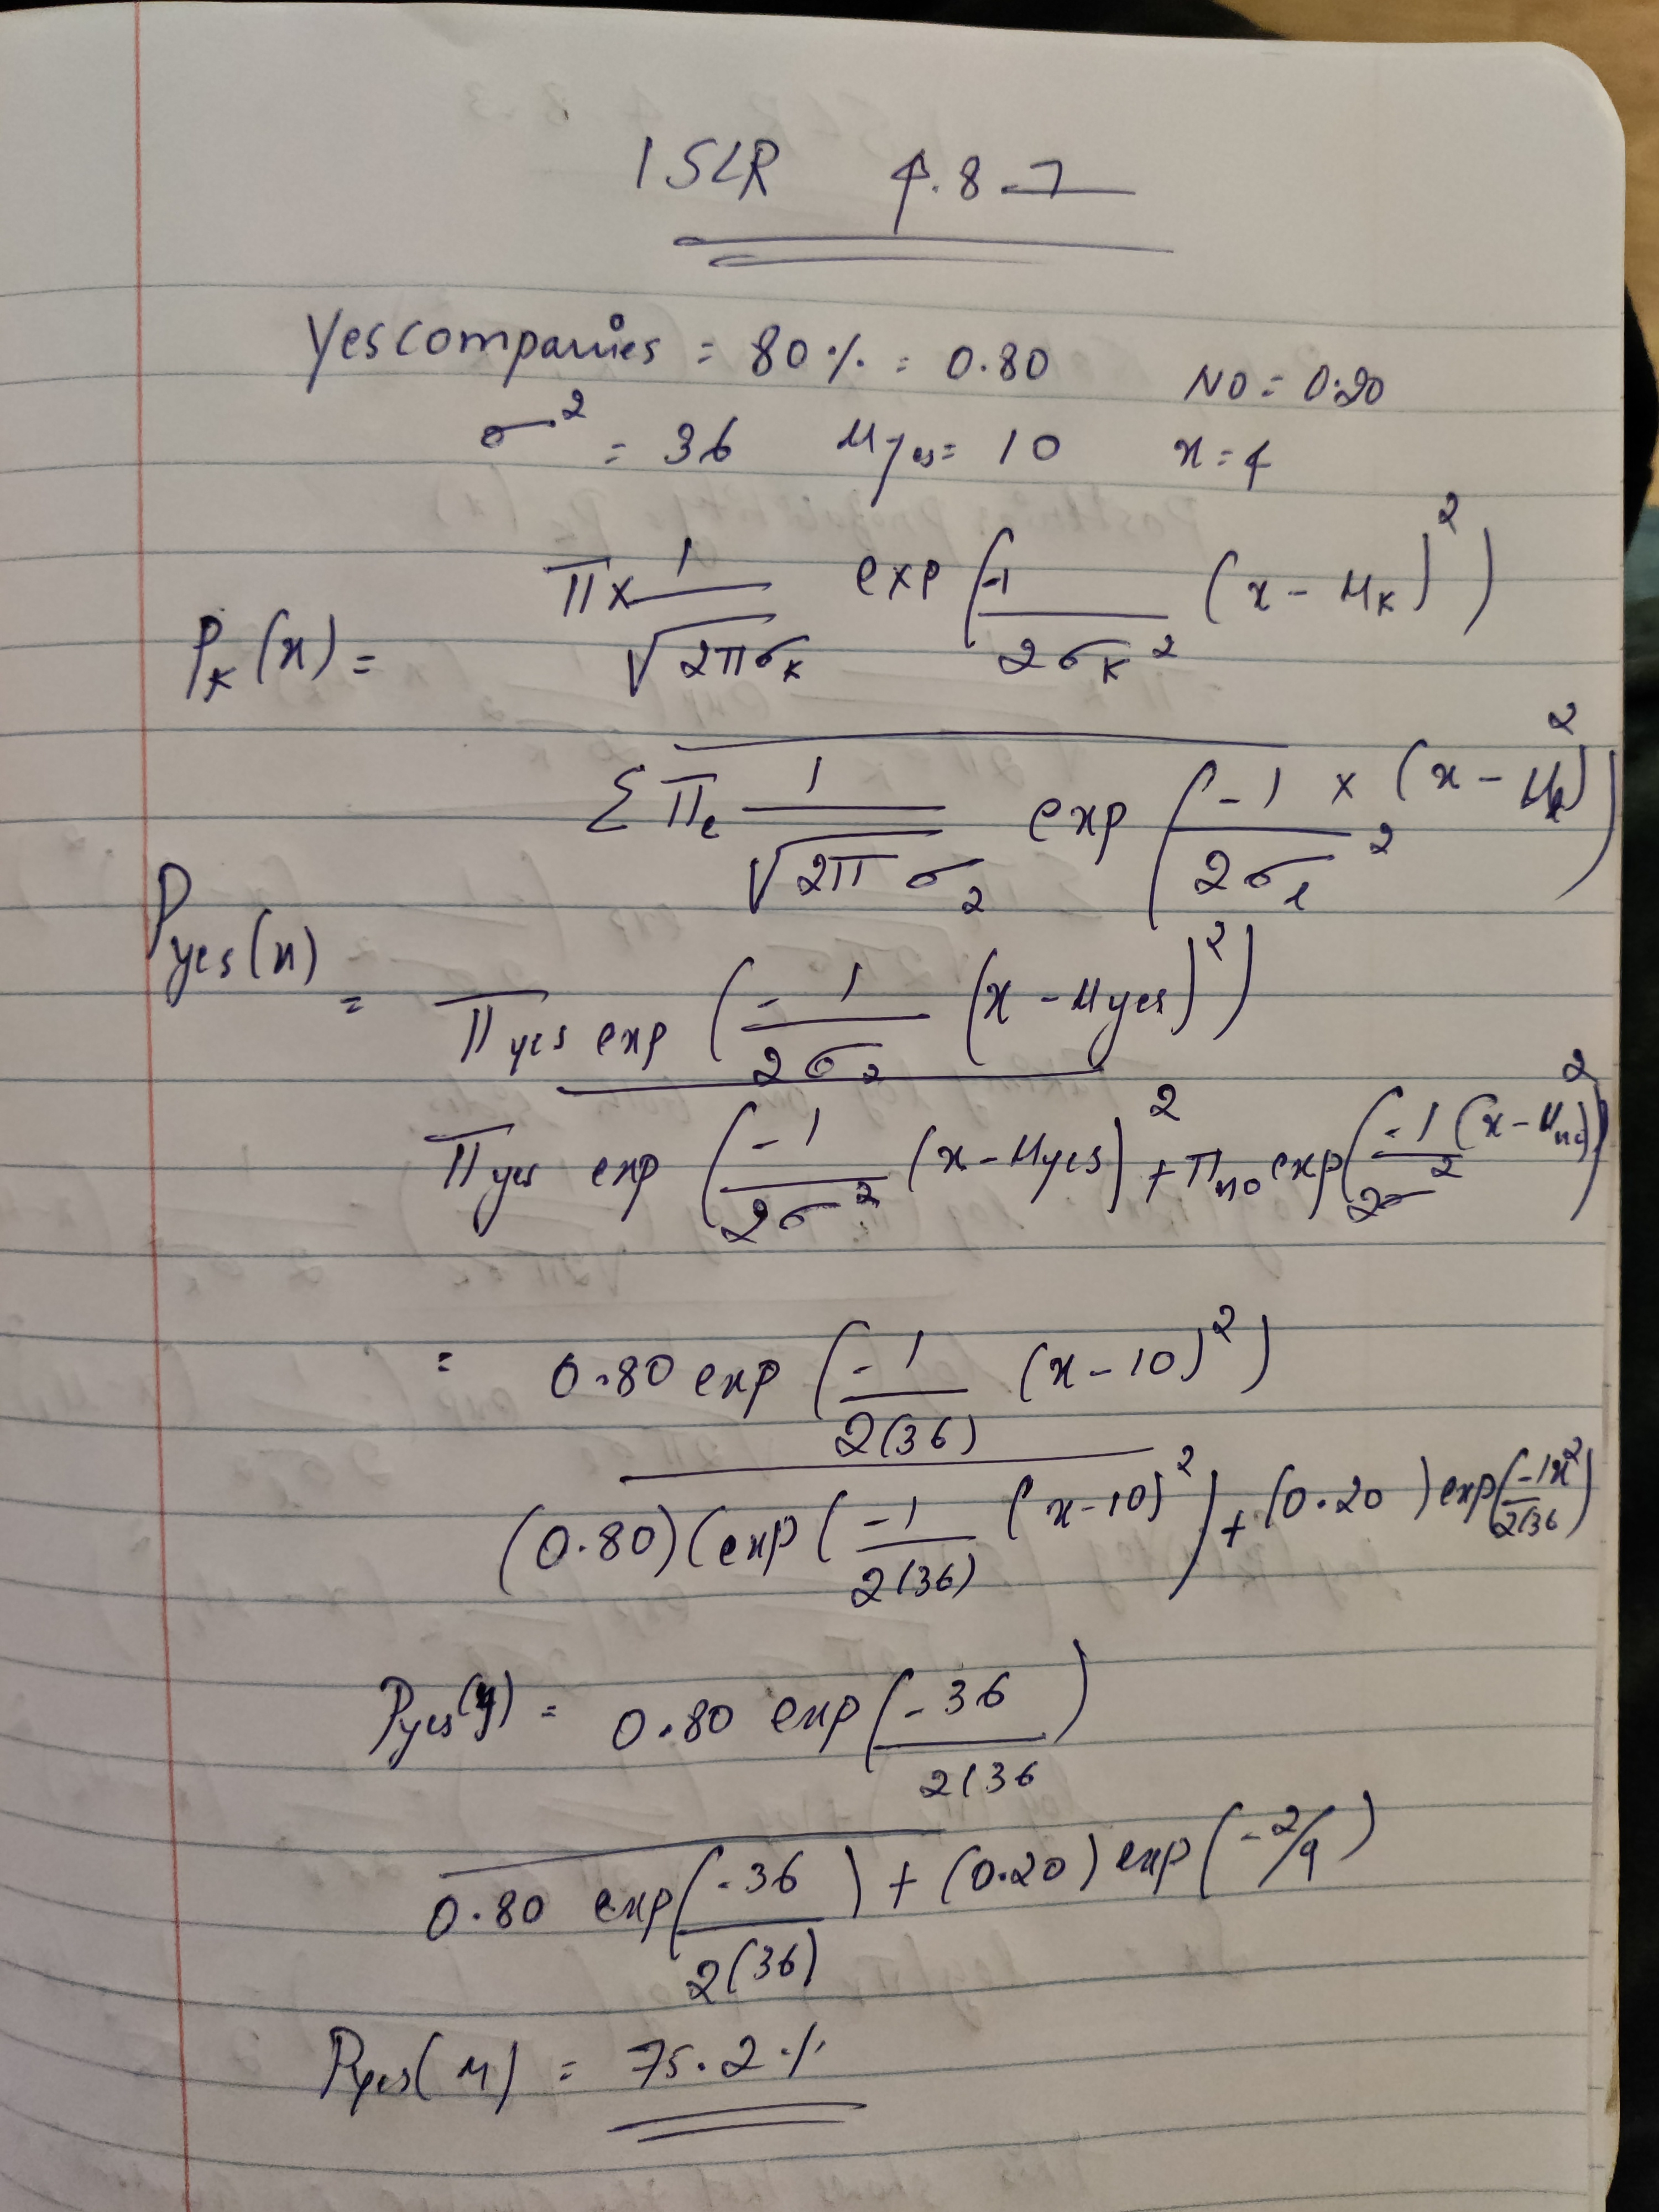

<h4>ISLR, 4.8.3

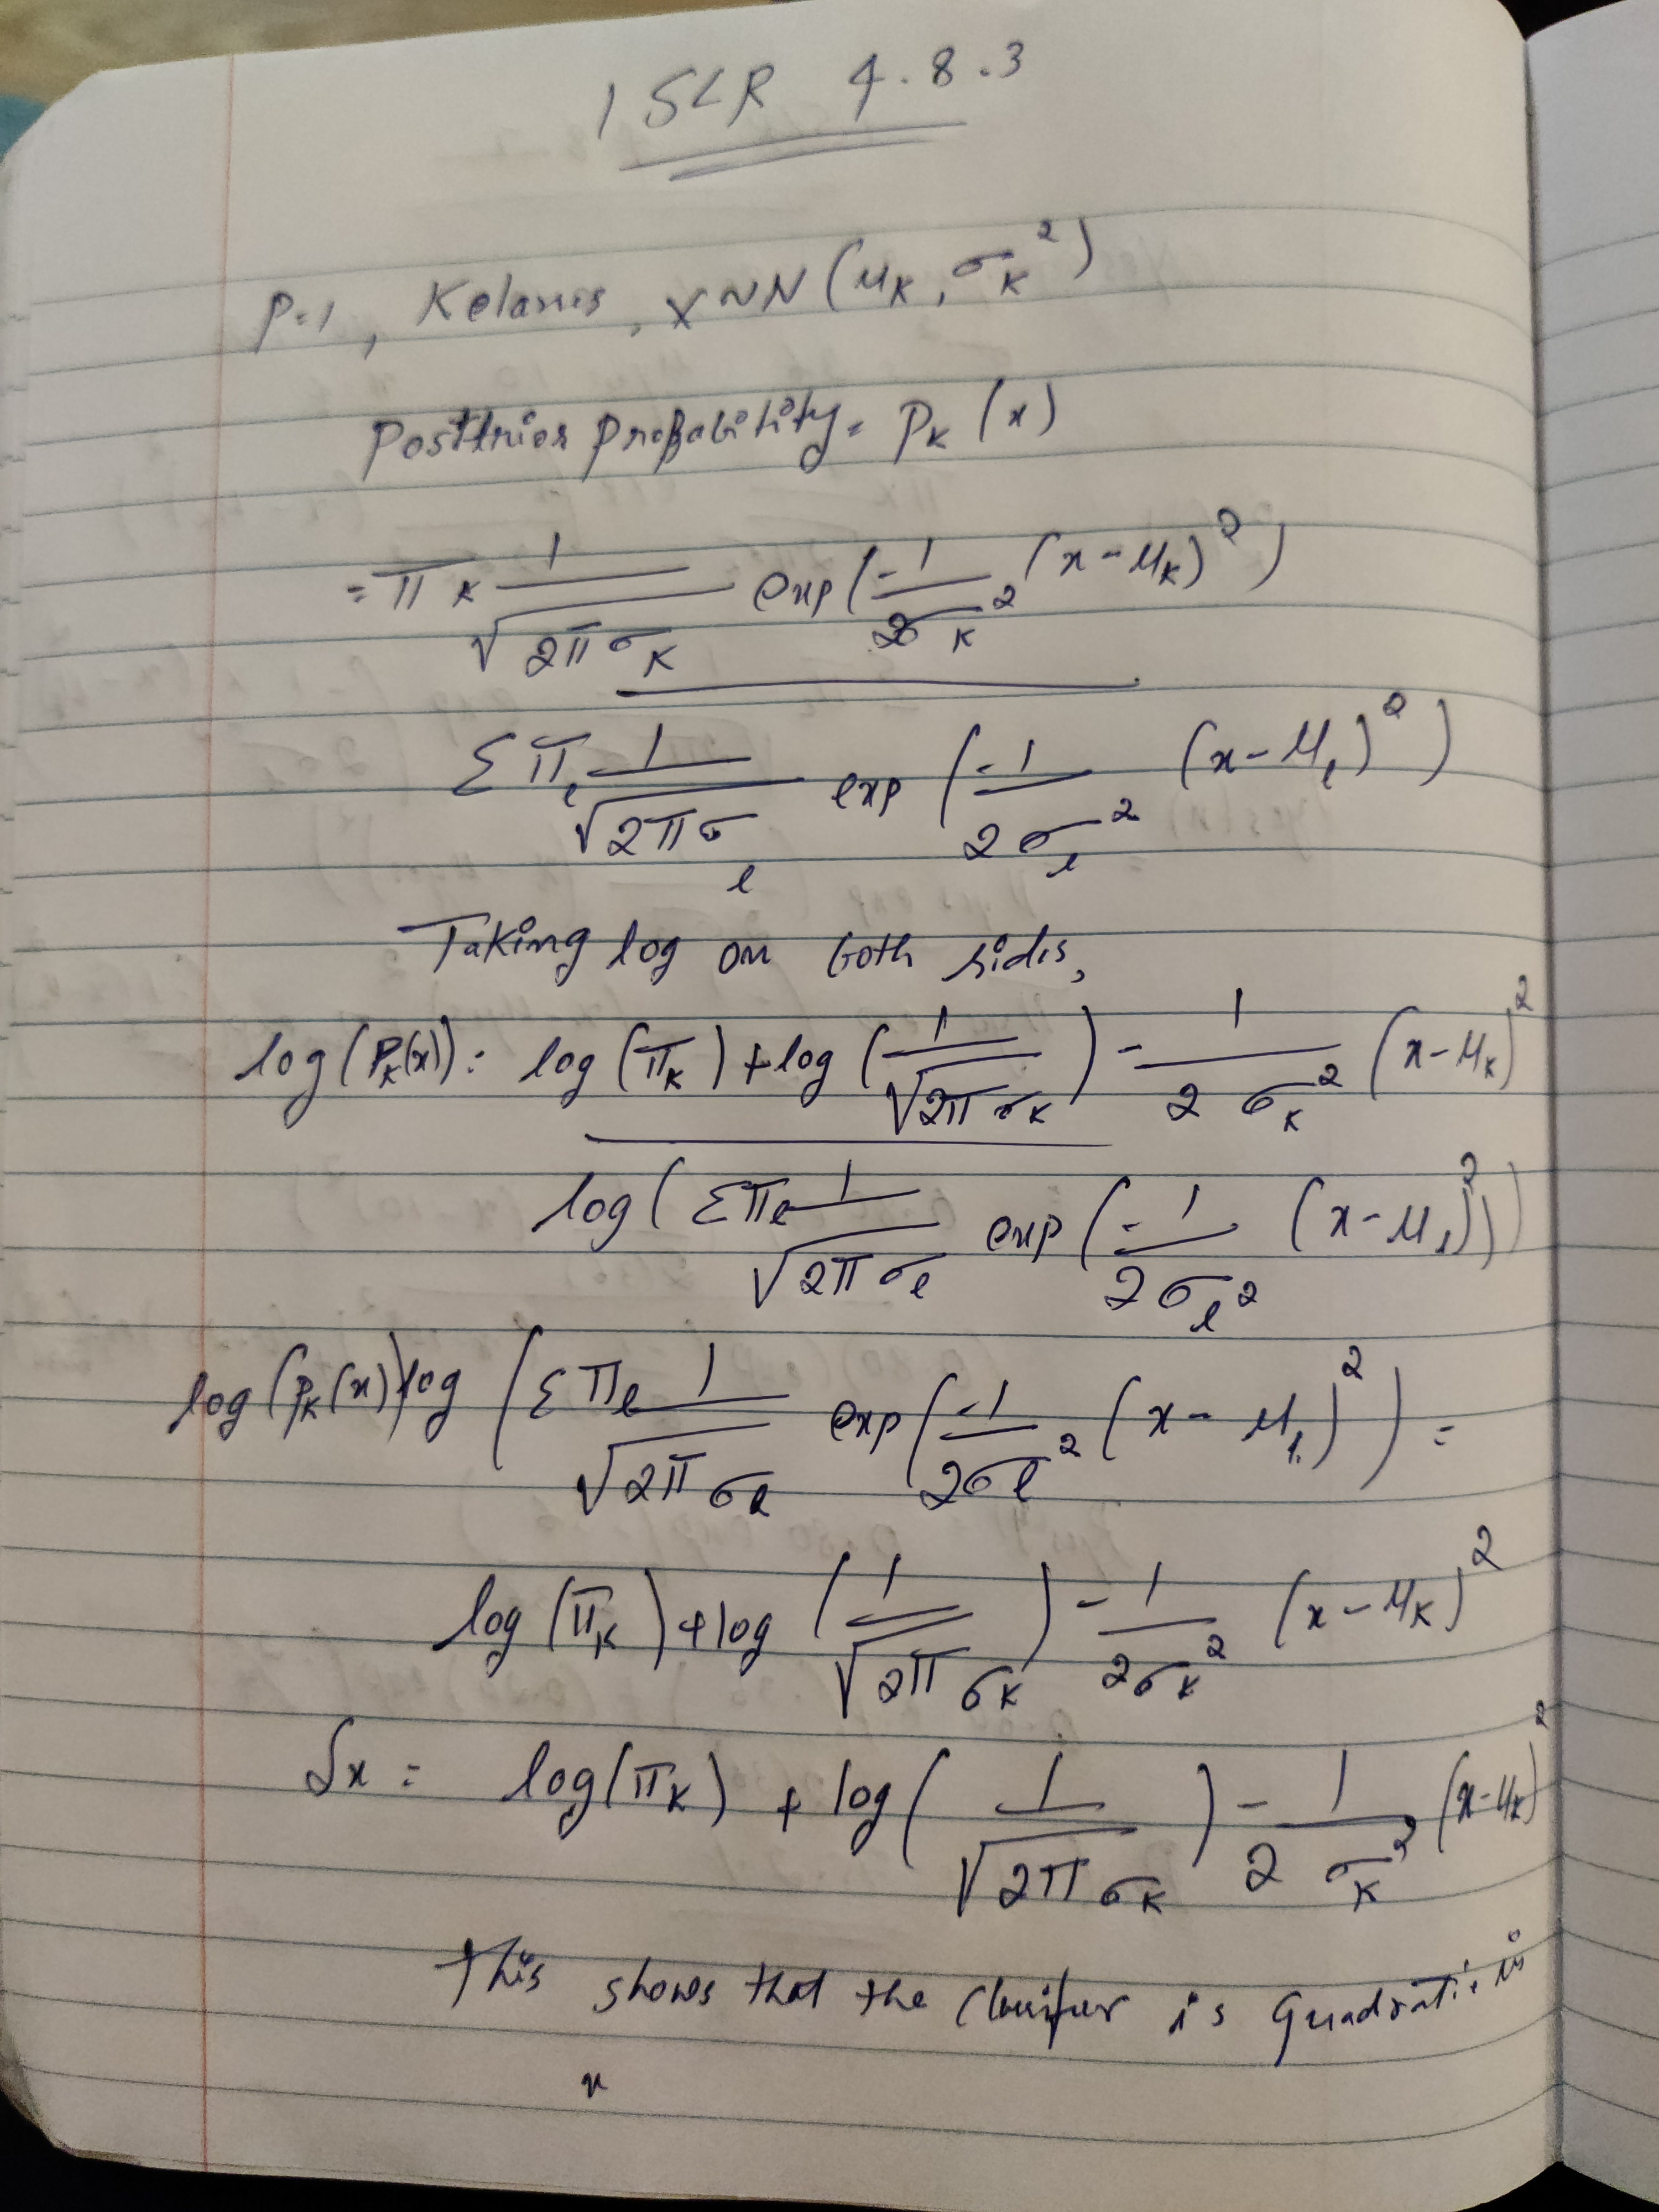